# Extraction des données d'un poste de Météo France
Ce cahier permet de visualiser les postes de Météo-France, d'extraire les données et de les traiter.

***Sources***. Pour cartographier des postes de mesure, je me suis appuyé notamment sur des scripts écrits par Loïc Duffar (https://github.com/loicduffar/meteo.data-Tools/). Pour l'analyse des valeurs extrêmes, je me sers du travail de George Bocharov (https://georgebv.github.io/pyextremes/), et en particulier son module pyextreme.

Météo-France a deux types de postes : les postes de mesures automatiques que j'appelle ici "climato" et les autres postes, qui sont essentiellement des postes de nivo-métérologie dans les stations de ski ou les balises Nivôse en altitude. Le problème est que si Météo-France fournit la liste des postes climatologiques sur son site internet, elle ne le fait pas pour les autres postes. Le seul moyen de le savoir est de télécharger tous les fichiers et examiner les numéros de poste. Un script "création-liste-poste.ipynb" fait ce travail fastidieux ; ce script génère une liste des postes non recensés par Météo-France et crée un fichier xlsx avec la localisation et d'autres informations sur ces postes. Il faut renseigner :
* l'adresse du répertoire où se situe le fichier, ici 
```
répertoire_postes = '/home/ancey/Météo-France/postes/'
```
* le nom du fichier, ici 
```
fichier_postes_alpes = 'liste_synthétique_Alpes_Nord.xlsx'
```
***Dépendance***. Les modules sont nécessaire : datetime, json, requests, plotly, gzip, scipy, openpyxl, pyextremes, termcolor.

L'installation peut se faire via pip ou conda. Il faut entièrement initialiser le code (les deux boîtes de "Initalisatoon et lecture du fichier JSON").

## Initialisation et lecture du fichier JSON  de Météo France

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import colors as mcolors
colors = mcolors._colors_full_map
import gzip
from tqdm import tqdm                             # barre de progression
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
import openpyxl                                   # exporte excel
from pyextremes import EVA                        # valeurs extrêmes  
from termcolor import colored                     # coloration du texte

plt.rcParams['text.usetex'] = True

################################
## Auteur : Christoophe Ancey ##
## Date : Mai 2024            ##
################################

#-------------------------------------------
# Lecture du fichier de postes  
#-------------------------------------------
# adresse du répertoire de travail
répertoire_principal = '/home/ancey/Météo-France/meteo.data/base'
# teste si le répertoire existe
if not os.path.exists(répertoire_principal):
    # s'il n'existe pas le créer
    os.makedirs(répertoire_principal)
    print("J'ai créé le répertoire : ", répertoire_principal)
else:
    print("J'ai trouvé le répertoire : ", répertoire_principal)
 
os.chdir(répertoire_principal)
print("Je me place dans le répertoire : "+os.getcwd())

# Ma liste de postes sur le disque
répertoire_postes = '/home/ancey/Météo-France/postes/'
fichier_postes_alpes = 'liste_synthétique_Alpes_Nord.xlsx'
if os.path.exists(répertoire_postes):
    liste_fichier = [f for f in os.listdir(répertoire_postes) if os.path.isfile(os.path.join(répertoire_postes, f))]
    if fichier_postes_alpes  in liste_fichier: 
        liste_postes_alpes = pd.read_excel(os.path.join(répertoire_postes,fichier_postes_alpes))
        liste_postes_alpes['poste'] = liste_postes_alpes['poste'].astype(str)
        print("J'ai téléchargé le fichier ", fichier_postes_alpes)
        # ce booléen indique si le fichier "fichier_postes_alpes" a été chargé
        chargement_nivo = True
    else:
        print(colored("Je n'ai pas trouvé de fichier des postes dans le répertoire principal.",'red'))
        print("Ce dernier peut être généré avec création_liste_postes.ipynb")
        chargement_nivo = False

# Météo France fournit un fichier JSON avec la liste de tous les postes
url_liste_postes= "https://www.data.gouv.fr/fr/datasets/r/1fe544d8-4615-4642-a307-5956a7d90922"
# Lecture en ligne du fichier JSON avec test de la connexion
requête = requests.get(url_liste_postes)
# teste si le fichier en ligne existe
if requête.status_code == 200:
    print("J'ai trouvé le fichier de Météo-France sur leur site. Je poursuis....")
    data_json= requête.json()
elif requête.status_code == 404:
    print(colored("Erreur : fichier non trouvé !",'red'))
    sys.exit()
else:
    print(colored("La requête a échoué. Le code d'erreur est ",'red'), requête.status_codes)
    sys.exit()
# il faut prendre le transposé (si cela plante, enlever ".T"). 
# MF semble ne pas fournir tout le temps le même format de fichier
metadata_MF = pd.DataFrame(data_json['features']).T

if metadata_MF.keys().to_list() != ['geometry', 'type', 'properties']:
    metadata_MF = pd.DataFrame(data_json['features'])

# fonction pour télécharger les fichiers MF
def télécharger_fichier(url, nom_fichier, work_verbosity = True):
    fichier = os.path.join(répertoire_principal, nom_fichier) + '.gz'
    if os.path.isfile(fichier):
        if work_verbosity: print("Rien à faire. Le fichier est déjà présent.")
    else:
        requête_données = requests.get(url)
        if requête_données.status_code == 200:
            with open(fichier,mode='wb') as file:
             file.write(requête_données.content)
            if work_verbosity: print('Téléchargement : ', fichier)    
        else:
            print(colored("Le lien "+ url+ "ne marche pas !",'red'))
            sys.exit()

# fonction pour décompresser les fichiers MF
def décompresser_archive(archive, work_verbosity = True):
    fichier             = os.path.join(répertoire_principal, archive) + '.gz'
    fichier_décompressé = os.path.join(répertoire_principal, archive) + '.csv'
    if os.path.isfile(fichier_décompressé):
        if work_verbosity: print("Rien à faire. Le fichier est déjà présent.")
    else:
        if os.path.exists(fichier):
            with gzip.open(fichier, mode='rb') as f_in:
                with open(fichier_décompressé, mode='wb') as f_out:
                    f_out.write(f_in.read())
            if work_verbosity: print('Archive décompressée : ', fichier)
        else:
            print(colored("L'archive ", fichier, " n'est pas présente !",'red'))
            print("Téléchargez tout d'abord l'archive...")

# début des mesures au niveau départemental
an_début = {}
an_début['01'] = '1852'
an_début['04'] = '1872'
an_début['05'] = '1877'
an_début['06'] = '1877'
an_début['25'] = '1852'
an_début['26'] = '1877'
an_début['38'] = '1872'
an_début['73'] = '1871'
an_début['74'] = '1876'
liste_départements = {'01','04','05','06','25','26','38','73','74'}
url_M1_département = {}
url_M2_département = {}
url_M3_département = {}
url_N1_département = {}
url_N2_département = {}
url_N3_département = {}
# adresse url de base
base_url = 	"https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_"
for département in liste_départements:
      url_N1_département[département] = base_url+département+"_"+an_début[département]+'-1949_autres-parametres.csv.gz'
      url_N2_département[département] = base_url+département+'_previous-1950-2022_autres-parametres.csv.gz'
      url_N3_département[département] = base_url+département+'_latest-2023-2024_autres-parametres.csv.gz'
      url_M1_département[département] = base_url+département+"_"+an_début[département]+'-1949_RR-T-Vent.csv.gz'
      url_M2_département[département] = base_url+département+'_previous-1950-2022_RR-T-Vent.csv.gz'
      url_M3_département[département] = base_url+département+'_latest-2023-2024_RR-T-Vent.csv.gz'

def lecture_bool(x:bool): 
      if x: return "oui"
      else:
            return "non"
      
noms_département = dict()
noms_département['73'] = "Savoie"
noms_département['74'] = "Haute-Savoie"
noms_département['38'] = "Isère"
noms_département['05'] = "Hautes-Alpes"
noms_département['04'] = "Alpes-de-Haute-Provence"
noms_département['06'] = "Alpes-Maritimes"
noms_département['01'] = "Ain"
noms_département['25'] = "Doubs"
noms_département['26'] = "Drôme"

def Lire_liste_postes(département):
    selection        = metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
    selection_nivo   = liste_postes_alpes[liste_postes_alpes['poste'].str.startswith(département)]
    df1 = pd.DataFrame()
    df1['nom'] = selection['nom_usuel'].apply(lambda x: x.title())
    df1['numéro'] = selection['num_poste']
    df1['alt'] = selection['alti']
    df1['lat'] = selection['lat']
    df1['lon'] = selection['lon']
    df1['type'] = 'poste MF'
    df2 = pd.DataFrame()
    df2['nom'] = selection_nivo['nom']
    df2['numéro'] = selection_nivo['poste']
    df2['alt'] = selection_nivo['alt']
    df2['lat'] = selection_nivo['lat']
    df2['lon'] = selection_nivo['lon']
    df2['type'] = 'nivo'
    if not df2['numéro'].eq(df1['numéro']).any():
        liste_tous_postes = pd.concat([df1,df2], ignore_index=True)
    liste_tous_postes = liste_tous_postes.sort_values(by=['nom'])
    liste_tous_postes = liste_tous_postes.reset_index(drop = True)
    return liste_tous_postes, selection

J'ai trouvé le répertoire :  /home/ancey/Météo-France/meteo.data/base
Je me place dans le répertoire : /home/ancey/Météo-France/meteo.data/base
J'ai téléchargé le fichier  liste_synthétique_Alpes_Nord.xlsx
J'ai trouvé le fichier de Météo-France sur leur site. Je poursuis....


In [2]:
# Ajout de colonnes 
metadata_MF['lat']      = metadata_MF['geometry'].apply(lambda x: x['coordinates'][1]).astype(float)
metadata_MF['lon']      = metadata_MF['geometry'].apply(lambda x: x['coordinates'][0]).astype(float)
metadata_MF['nom_usuel']= metadata_MF['properties'].apply(lambda x: x['NOM_USUEL'].strip())
metadata_MF['num_poste']= metadata_MF['properties'].apply(lambda x: x['NUM_POSTE'].strip())
metadata_MF['commune']  = metadata_MF['properties'].apply(lambda x: x['COMMUNE'].strip())
metadata_MF['ficheClimComplete'] = metadata_MF['properties'].apply(lambda x: x['ficheClimComplete']).astype(float)
metadata_MF['ficheClimReduite']  = metadata_MF['properties'].apply(lambda x: x['ficheClimReduite']).astype(float)
metadata_MF['alti']              = metadata_MF['properties'].apply(lambda x: x['ALTI'])

# sauvegarde dans un fichier excel plus lisible que le JSON après suppression des colonnes type, geometry et properties
metadata_MF.drop(['type', 'geometry', 'properties'], axis=1, inplace=True)

# ajoute une colonne à metadata_MF avec une url composée de la concaténation d'une racine constante et du numéro de poste
metadata_MF['url_metadata']     = 'https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee='+ metadata_MF['num_poste']
metadata_MF['ficheClimComplete']= metadata_MF['ficheClimComplete'].astype(int)
metadata_MF['ficheClimReduite'] = metadata_MF['ficheClimReduite'].astype(int)
# trie suivant num_poste
metadata_MF.sort_values(by= ['num_poste'], inplace=True)
display(metadata_MF)

lat         lon                nom_usuel num_poste     commune  \
0     46.278167    5.669000                   ARBENT  01014002      ARBENT   
1     45.833000    5.106667               BALAN_AERO  01027003       BALAN   
2     46.122000    4.904500                  BANEINS  01028001     BANEINS   
3     46.086500    5.814167               BELLEGARDE  01033002  VALSERHONE   
4     45.769333    5.688000                   BELLEY  01034004      BELLEY   
...         ...         ...                      ...       ...         ...   
2389 -21.318167  165.002167                   NEPOUI  98827002        POYA   
2390 -20.789333  165.254500             TOUHO AEROD.  98830002       TOUHO   
2391 -22.156500  166.939000                YATE MRIE  98832002        YATE   
2392 -22.132667  166.726333          RIVIERE BLANCHE  98832006        YATE   
2393 -22.269167  166.967500  GORO_ANCIENNE_PEPINIERE  98832101        YATE   

      ficheClimComplete  ficheClimReduite  alti  \
0                     0                 1   534   
1                     0                 0   196   
2                     0                 1   243   
3                     1                 1   350   
4                     0                 1   330   
...                 ...               ...   ...   
2389                  1                 1    82   
2390                  0                 1     2   
2391                  0                 1    25   
2392                  0                 1   171   
2393                  0                 1   298   

                                           url_metadata  
0     https://publitheque.meteo.fr/okapi/_composants...  
1     https://publitheque.meteo.fr/okapi/_composants...  
2     https://publitheque.meteo.fr/okapi/_composants...  
3     https://publitheque.meteo.fr/okapi/_composants...  
4     https://publitheque.meteo.fr/okapi/_composants...  
...                                                 ...  
2389  https://publitheque.meteo.fr/okapi/_composants...  
2390  https://publitheque.meteo.fr/okapi/_composants...  
2391  https://publitheque.meteo.fr/okapi/_composants...  
2392  https://publitheque.meteo.fr/okapi/_composants...  
2393  https://publitheque.meteo.fr/okapi/_composants...  

[2394 rows x 9 columns]

## Trace la carte des postes actifs

In [3]:
# trace une carte plotly des points et sauvegarde tout dans des fichier excel, html et png
fig = px.scatter_mapbox(metadata_MF, 'lat', lon= 'lon', 
                        hover_name= "nom_usuel", hover_data= ["num_poste", 'alti', "commune", 'ficheClimComplete', 'ficheClimReduite'], 
                        zoom=5, height= 800, width= 900, 
                        )

now= datetime.datetime.now()
title= 'Postes Météo-France en activité en ' + now.strftime("%Y")
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(marker=dict(color='red'))

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=5, mapbox_center = {"lat": 46.5, "lon": 2.}
                  )


### Export

In [ ]:
# Export vers html
file_start= 'postes_meteo-france'
file_map= file_start + '- carte_' + now.strftime("%Y-%m-%d")
fig.write_html(os.path.join(répertoire_principal, file_map + '.html'))

In [ ]:
# Export PNG
file_start= 'postes_meteo-france'
file_map= file_start + '_carte_' + now.strftime("%Y-%m-%d")
file_png= os.path.join(répertoire_principal, file_map + '.png')
fig.write_image(file_png)

In [ ]:
# Export vers Excel du fichier JSON + ajout des urls de fiche de métadonnées
file_excel   = os.path.join(répertoire_principal, file_start + ' - liste_' + now.strftime("%Y") + '.xlsx')
onglet_liste = 'liste'
metadata_MF.to_excel(file_excel, index=False, sheet_name= onglet_liste)

wb = openpyxl.load_workbook(file_excel) # Chargement du classeur existant
ws = wb[onglet_liste] # récupère onglet_liste
#ws.add_image(openpyxl.drawing.image.Image(file_png), 'J3') # ajoute l'image png de la carte
# ajoute un texte
ws['N1']= 'Version geoJSON'
ws['P1']= 'https://gist.github.com/2803media/84acfec402ce2210f5c38e6d7de3f39b'

# Ajoute un nouvel onglet au fichier excel, avec une brute de json.dumps(data_json, indent=4)
onglet_json= 'JSON'
ws = wb.create_sheet(onglet_json) # Création d'une nouvelle feuille
for i, line in enumerate(json.dumps(data_json, indent=4).split('\n'), start=1): # Ajout de la chaîne ligne par ligne à la nouvelle feuille
    ws[f'A{i}'] = line

wb.save(file_excel) # Sauvegarde du classeur



## Carte pour un département

In [4]:
# interroge les poste d'un département donné
département= '38'
# sélection des données du département choisi
selection=metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
# calcul du centre du département (latitude et longitude)
m_lat=np.mean(np.array(selection.lat))
m_lon=np.mean(np.array(selection.lon))


if chargement_nivo: liste_tous_postes, _ = Lire_liste_postes(département)

### Carte des postes climatologiques

In [5]:
# trace une carte plotly des points et sauvegarde tout dans des fichier excel, html et png
fig = px.scatter_mapbox(selection, 'lat', lon= 'lon', 
                        hover_name= "nom_usuel", hover_data= ["num_poste", 'alti', "commune", 'ficheClimComplete', 'ficheClimReduite'], 
                        height= 800, width= 900, 
                        )

now= datetime.datetime.now()
title= noms_département[département] + ' : postes Météo-France en activité en ' + now.strftime("%Y")
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(marker=dict(color='red'))

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})

# Export PNG
racine_carte = 'postes_climato_meteo-france'
nom_carte    = racine_carte + '_carte_' + now.strftime("%Y")
nom_complet  = os.path.join(répertoire_principal, nom_carte + '.png')
fig.write_image(nom_complet)

fig

### Carte de tous les postes

In [6]:

if chargement_nivo:
    fig = px.scatter_mapbox(liste_tous_postes, lat ='lat', lon= 'lon',  
                        hover_name= "nom", hover_data= ["numéro", 'alt','type'], 
                        zoom=5, height= 800, width= 900,   
                        color = 'type'
                        )

    fig.update_traces(
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=1.0
        )
    )
 
    #===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
    fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
    fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})

    fig.show()
else:
    print("La carte ne peut être affichée car les données des postes nivologiques n'ont pas été chargées.")

# Export PNG
racine_carte = 'tous_postes_meteo-france'
nom_carte    = racine_carte + '_carte_' + now.strftime("%Y")
nom_complet  = os.path.join(répertoire_principal, nom_carte + '.png')
fig.write_image(nom_complet)


### Liste des stations pour un département

In [7]:
if chargement_nivo:
      information_selection = (liste_tous_postes.sort_values(by=['nom']))[['nom','numéro','alt']]
else:
      information_selection = (selection.sort_values(by=['commune']))[['num_poste','commune','nom_usuel','alti']]
      #print(tabulate(information_selection, showindex=False, headers=metadata_MF.columns)) 
display((information_selection.style.hide()).set_properties(**{'text-align': 'left'}))


# Sélection d'un poste climatologique de Météo-France

## Lecture du fichier et désignation du poste

In [ ]:
# charge le fichier JSON de Météo-France avec toutes les stations
# Le fichier JSON contient la liste et le lien de tous les fichiers de données
url_data_MF      = "https://www.data.gouv.fr/api/2/datasets/6569b51ae64326786e4e8e1a/"
nouvelle_requête = requests.get(url_data_MF)
if nouvelle_requête.status_code == 200:
    print("J'ai trouvé sur le site de Météo-France leur fichier fournissant la liste des données. Je poursuis....")
    metadata_MF = nouvelle_requête.json()
elif nouvelle_requête.status_code == 404:
    print("Erreur : fichier non trouvé !")
    sys.exit()
else:
    print("La requête a échoué. Le code d'erreur est ", nouvelle_requête.status_codes)
    sys.exit()
# on calcul le nombre de fichiers disponibles 
nb_data =  metadata_MF['resources']['total'] 
url_fichiers_MF  = "https://www.data.gouv.fr/api/2/datasets/6569b51ae64326786e4e8e1a/resources/?page=1&page_size={:d}&type=main".format(nb_data)
liste_brute_dict = (requests.get(url_fichiers_MF)).json()
liste_brute      = pd.DataFrame(liste_brute_dict['data'])

 

In [ ]:
#----------------------------------
# Indiquer le poste à analyser :
#----------------------------------
poste_choisi = '73144001'
poste_choisi = '73290002'
poste_choisi = '73144001'
# interroge les poste d'un département donné
département= poste_choisi[0:2]
# sélection des données du département choisi
try:
    selection
except NameError:
    selection=metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
# calcul du centre du département (latitude et longitude)
m_lat=np.mean(np.array(selection.lat))
m_lon=np.mean(np.array(selection.lon))

try:
     liste_tous_postes
except NameError:
      if chargement_nivo: 
           liste_tous_postes = Lire_liste_postes(département)
      else:
           print("Il y a un problème ! Je ne peux charger la liste des postes.")

# Fiche de poste
if selection[selection['num_poste']==poste_choisi ].empty:
      print("Pas de poste dans le fichier des postes actifs. ")
      if liste_tous_postes[liste_tous_postes['numéro']==poste_choisi ].empty:
            print("Je n'ai pas trouvé ce poste dans la liste des postes nivo-météo.")
      else:
            print("J'ai trouvé ce poste dans la liste des postes nivo-météo. Il faut voir plus bas pour télécharger les fichiers...")
else:     
      url_poste   = selection[selection['num_poste']==poste_choisi]['url_metadata']
      nom_poste   = selection[selection['num_poste']==poste_choisi]['nom_usuel'].to_string(index=False).title()
      nom_commune = selection[selection['num_poste']==poste_choisi]['commune'].to_string(index=False).title()
      alti_poste  = selection[selection['num_poste']==poste_choisi]['alti']
      print("Le poste est : ",nom_poste, " dans la commune de "+nom_commune,
            "; l' altitude :", alti_poste.to_string(index=False),"m.")
      print("La fiche du poste est consultable en ligne : ",np.array(url_poste)[0])

## Extraction des données

In [ ]:
# Création du répertoire de travail
répertoire_travail = répertoire_principal +"/"+ département+"/"
# teste si le répertoire existe existes
if not os.path.exists(répertoire_travail):
    # crée le répertoire
    os.makedirs(répertoire_travail)
    print("J'ai créé le répertoire : ", répertoire_travail)
else:
    print("J'ai trouvé le répertoire : ",répertoire_travail)


In [ ]:
# Précipitations et températures
nom_fichier_1 = "Q_"+département+"_previous-1950-2022_RR-T-Vent.csv.gz"
nom_fichier_2 = "Q_"+département+"_latest-2023-2024_RR-T-Vent.csv.gz"
# neige
nom_fichier_3 = "Q_"+département+"_previous-1950-2022_autres-parametres.csv.gz"
nom_fichier_4 = "Q_"+département+"_latest-2023-2024_autres-parametres.csv.gz"

# Météo 1950-2022 + 2022-2024
lien_1 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_1]))))]['url'])[0]
lien_2 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_2]))))]['url'])[0]
# Neige 1950-2022 + 2022-2024
lien_3 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_3]))))]['url'])[0]
lien_4 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_4]))))]['url'])[0]
# Pour les années antérieures à 1950
filtre1 = liste_brute[liste_brute['url'].str.contains("Q_73")]['url']
# Météo avant 1950
lien_5  = np.array(filtre1[filtre1.str.contains("1949_RR")])[0]
# Nivo avant 1950
lien_6  = np.array(filtre1[filtre1.str.contains("1949_autre")])[0]

### Données météorologiques 1950-2024

In [ ]:
# Chargement des données 1950-2022
#----------------------------------
nom_csv_1 = "météo-1950-2022"
fichier   = os.path.join(répertoire_travail, nom_csv_1) + '.csv'
if os.path.isfile(fichier): print("j'ai trouvé le fichier "+nom_csv_1)
télécharger_fichier(lien_1, nom_csv_1)
décompresser_archive(nom_csv_1)
données_totales_1 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_1 = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
pluie_1 = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["RR"]
Tmin_1  = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["TN"]
Tmoy_1  = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["TM"]
Tmax_1  = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["TX"]

In [ ]:
# Chargement des données 2022-2024
#----------------------------------
nom_csv_2 = "météo-2022-2024"
fichier   = os.path.join(répertoire_travail, nom_csv_2) + '.csv'
if os.path.isfile(fichier): print("j'ai trouvé le fichier "+nom_csv_2)
télécharger_fichier(lien_2, nom_csv_2)
décompresser_archive(nom_csv_2)
données_totales_2 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_2 = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
pluie_2 = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["RR"]
Tmin_2  = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["TN"]
Tmoy_2  = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["TM"]
Tmax_2  = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["TX"]

In [ ]:
#agrégration des fichiers
dates = pd.concat([dates_1,dates_2])
pluie = pd.concat([pluie_1,pluie_2])
Tmin  = pd.concat([Tmin_1,Tmin_2])
Tmoy  = pd.concat([Tmoy_1,Tmoy_2])
Tmax  = pd.concat([Tmax_1,Tmax_2])
# création de la série temporelle des pluies et température
série = pd.DataFrame()
série['date']  = dates
série['pluie'] = pluie
série['Tmin'] = Tmin
série['Tmoy'] = (Tmin+Tmax)/2
série['Tmax'] = Tmax
 
# Nettoyage
série.fillna(method='ffill', inplace=True)

## Analyse des pluies

### Série temporelle

In [ ]:
# distribution temporelle des pluies
fig, axs = plt.subplots(figsize=(16, 4))
axs.bar(dates,pluie,width=20)
axs.set_xlabel("date")
axs.set_ylabel("valeur en eau [mm]")
fig.savefig("Evolution_Precipitation_poste_"+poste_choisi+".pdf",bbox_inches='tight')
pluie_max = np.nanmax(pluie)
date_max = dates[pluie == pluie_max].to_string(index=False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
axs.grid(axis='y', color='grey',alpha = 0.5)
print(f"La précipitation maximale a été observée le {date_max} et valait {pluie_max:.1f} mm." )

fig.savefig("Evolution_annuelle_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

In [ ]:
cumul_mensuel = série.groupby(by = [série['date'].dt.month, série['date'].dt.year])['pluie'] .sum()
dates_cum     = série.groupby(by = [série['date'].dt.month, série['date'].dt.year])['date'].first()

cumul_annuel  = série.groupby(by = [série['date'].dt.year])['pluie'] .sum()
dates_an      = série.groupby(by = [série['date'].dt.year])['date'].first()


# Ajuste l'année de départ
véritable_année_début = dates_an[(cumul_annuel>0) & (dates_an.dt.month == 1)].first_valid_index()
print("Année de début avec données complète : ", véritable_année_début)
cumul_mensuel = cumul_mensuel[dates_cum.dt.year>véritable_année_début]
dates_cum     = dates_cum[dates_cum.dt.year>véritable_année_début]

cumul_annuel  = cumul_annuel[dates_an.dt.year>véritable_année_début]
dates_an      = dates_an[dates_an.dt.year>véritable_année_début]

#cumul mensuel de précipitation
fig, axs = plt.subplots(figsize=(12, 4))

plt.grid(axis='y', color='gray', alpha=0.25) 
plt.grid(axis='x', color='gray', alpha=0.95)
axs.bar(dates_cum,cumul_mensuel,width=100)
axs.set_ylabel(r'$P_{mens}$  [mm]')
axs.set_xlabel(r'date')
fig.savefig("Evolution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(12, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(dates_an,cumul_annuel,width=200)

axs.set_ylabel(r'$P_{an}$  [mm]')
axs.set_xlabel(r'date')
fig.savefig("Evolution_cumul_annuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
print("Le cumul annuel de précipitations esz {:.0f} mm".format(cumul_annuel.mean()))

In [ ]:
# évolution des précipitations journalières au cours d'une année
jour_civil = np.array(dates.dt.dayofyear)
valP       = np.array(pluie)
moyenne_pluie = []
for i in range(1,367):
    moyenne_pluie.append(np.nanmean(pluie[jour_civil == i] ))  
fig, axs = plt.subplots(figsize=(8, 4))
axs.scatter(jour_civil,valP, alpha = 0.1)
axs.plot(moyenne_pluie,color = "red")
axs.set_ylabel(r'$P$ [mm]')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
print("La pluie journalière moyenne est P = {:0.1f} mm.".format(np.mean(moyenne_pluie)))

In [ ]:
# distribution des cumuels mensuels de précipitation au cours d'une année
cumul_mensuel.index.get_level_values(0)
moyenne_cumul_mensuel = cumul_mensuel.groupby(by = [cumul_mensuel.index.get_level_values(0)]).mean()

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(8, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(1+np.arange(12),moyenne_cumul_mensuel,width=1,color='lightskyblue',edgecolor = 'k')

axs.set_ylabel(r'cumul mensuel  [mm]')
axs.set_xlabel(r'mois')
axs.set_xticks(1+np.arange(12), ['jan', 'fév', 'mars','avr.','mai','juin','juil.','août', 'sep.', 'oct.' , 'nov.' ,'déc.'])
fig.savefig("Distribution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

### Analyse des valeurs extrêmes

In [ ]:
# Analyse des valeurs extrêmes
série_pluie = pd.Series(np.array(pluie),index=np.array(dates)).squeeze()
#série_pluie.fillna(method='ffill', inplace=True)
model = EVA(série_pluie)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model

In [ ]:
model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model

In [ ]:

fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$")
axes.set_ylabel(r"$P$ [mm]")


In [ ]:
from scipy.stats import gumbel_r, genextreme 
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_précipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig

In [ ]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


### Analyse des températures

In [ ]:
température_annuelle  = np.array(série.groupby(by = [série['date'].dt.year])['Tmoy'].mean())
dates_température     = série.groupby(by = [série['date'].dt.year])['date'].first()
dates_température_an  = np.array(dates_température.dt.year)
slope, intercept, r_value, p_value, std_err = stats.linregress(dates_température_an, température_annuelle)
trendline = intercept + slope*dates_température_an

fig, axs = plt.subplots(figsize=(16, 4))
axs.plot(dates,Tmin,color = "skyblue", alpha = 0.5, label = "température minimale")
axs.plot(dates,Tmax,color = "red", alpha = 0.5, label = "température maximale")
axs.plot(dates_température,trendline,color = "black", alpha = 0.95, label = "tendance linéaire")
axs.set_ylabel("Température [°C]")
axs.grid(axis='y', color='grey', alpha = 0.7)
fig.legend(loc = "outside upper left")
print("On observe un accroissement de température de {:.1f} °C par siècle.".format(100*slope))

fig.savefig("Evolution_Tendance_Température_poste_"+poste_choisi+".pdf",bbox_inches='tight')

In [ ]:
série_température = pd.Series(np.array(Tmoy),index=np.array(dates)).squeeze()
série_température.resample('M').mean()

fig, axs = plt.subplots(figsize=(16, 4))
axs.scatter(dates,Tmin,color = "skyblue", alpha = 0.2, label = "température minimale")
axs.scatter(dates,Tmax,color = "red", alpha = 0.05, label = "température maximale")
axs.plot(dates_température,trendline,color = "black", alpha = 0.95, label = "tendance linéaire long terme")
axs.set_ylabel("Température [°C]")
axs.grid(axis='y', color='grey', alpha = 0.7)



axs.plot(série_température.resample('M').mean(), color = 'darkgreen', label = "moyenne mensuelle")
fig.legend(loc = "outside upper left")
fig.savefig("Evolution_température_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

### Evolution de la température au cours de l'année

In [ ]:
# évolution des températures au cours d'une année
jour_civil = np.array(dates.dt.dayofyear)
valT = 0.5*(np.array(série["Tmin"])+np.array(série["Tmax"]))
moyenne_Température = []
for i in range(1,367):
    moyenne_Température.append(np.nanmean(valT[jour_civil == i] ))  
fig, axs = plt.subplots(figsize=(8, 4))
axs.scatter(jour_civil,valT, alpha = 0.1)
axs.plot(moyenne_Température,color = "red")
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
print("La température journalière moyenne est T = {:0.1f} °C.".format(np.mean(moyenne_Température)))

In [ ]:
# Evolution moyenne de la température au fil de la saison
jour_civil = np.array(dates.dt.dayofyear)

jour_civil_2024  = np.array(série[série['date'].dt.year == 2024]['date'].dt.dayofyear)
température_2024 = np.array(série[série['date'].dt.year == 2024]['Tmoy'])

valT = np.array(série["Tmoy"])
moyenne_température = []
for i in range(1,367):
    moyenne_température.append(np.nanmean(valT[jour_civil == i] ))  

fig, axs = plt.subplots(figsize=(12, 4))
diag_TM = axs.scatter(jour_civil,valT, alpha = 0.2, c=np.array(série['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_2024,température_2024, alpha = 0.75, marker = "s", color = "black", label = "2024" )
axs.plot(moyenne_température,color = "indigo", linewidth=3.0, label = "Moyenne des température")
cbar = fig.colorbar(diag_TM)
cbar.ax.set_title('année', rotation=0)
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
fig.legend(loc='outside upper center')
axs.grid(axis="y",alpha=0.5)
fig.savefig("Evolution_annuelle_Température_poste_"+poste_choisi+".pdf",bbox_inches='tight')

### Données nivologiques 1950-2024

In [ ]:
# années 1950-2022
nom_csv_1 = "nivo-1950-2022"
fichier   = os.path.join(répertoire_travail, nom_csv_1) + '.csv'
print(fichier)
télécharger_fichier(lien_3, nom_csv_1)
décompresser_archive(nom_csv_1)
données_totales_3 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_1   = données_totales_3[données_totales_3["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
chute_1   = données_totales_3[données_totales_3["NUM_POSTE"]==int(poste_choisi) ]["HNEIGEF"]
hauteur_1 = données_totales_3[données_totales_3["NUM_POSTE"]==int(poste_choisi) ]["NEIGETOTX"]

# années 2023-2024
nom_csv_2 = "nivo-2023-2024"
fichier   = os.path.join(répertoire_travail, nom_csv_2) + '.csv'
print(fichier)
télécharger_fichier(lien_4, nom_csv_2)
décompresser_archive(nom_csv_2)
données_totales_4 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_2   = données_totales_4[données_totales_4["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
chute_2   = données_totales_4[données_totales_4["NUM_POSTE"]==int(poste_choisi) ]["HNEIGEF"]
hauteur_2 = données_totales_4[données_totales_4["NUM_POSTE"]==int(poste_choisi) ]["NEIGETOTX"]


In [ ]:
# agrégation des données
dates    = pd.concat([dates_1,dates_2])
chute    = pd.concat([chute_1,chute_2])
hauteur  = pd.concat([hauteur_1,hauteur_2])
série_neige = pd.DataFrame()
série_neige['date']  = dates
série_neige['chute'] = chute
série_neige['hauteur'] = hauteur
# Nettoyage
série_neige.fillna(method='ffill', inplace=True)

if série_neige[~série_neige['chute'].isna()].empty: 
      print("pas de données de chutes de neige")
      existe_chute = False
else:
      if série_neige[~série_neige['chute'].isna()]['chute'].max() == 0: 
            print("Je trouve bien des données, mais elles sont nulles !")
            existe_chute = False
      else:
            print("J'ai trouvé {:.0f} valeurs en tout".format(série_neige[~série_neige['chute'].isna()]['chute'].count()))
            existe_chute = True

if série_neige[~série_neige['hauteur'].isna()].empty: 
      print("pas de données de hauteur de neige")
      existe_hauteur = False
else:
      if série_neige[~série_neige['hauteur'].isna()]['hauteur'].max() == 0: 
            print("Je trouve bien des données, mais elles sont toute nulles !")
            existe_hauteur = False
      else:
            print("J'ai trouvé {:.0f} valeurs en tout".format(série_neige[~série_neige['hauteur'].isna()]['hauteur'].count()))
            existe_hauteur = True


In [ ]:
# variation de la hauteur de neige
if existe_hauteur:
      fig, axs = plt.subplots(figsize=(16, 4))
      axs.plot(dates,hauteur)
      axs.set_ylabel(r'$H $  [cm]')
      axs.set_xlabel(r'date')
else:
      print("Pas de données !")

In [ ]:
# variation des chutes de neige
if existe_chute:
      fig, axs = plt.subplots(figsize=(16, 4))
      axs.scatter(dates[chute>0],chute[chute>0],   marker = "." , color='deepskyblue', alpha=0.75)
      axs.set_ylabel(r'$C$  [cm]')
      axs.set_xlabel(r'date')
else:
      print("Pas de données !")

In [ ]:


cumul_mensuel = série_neige.groupby(by = [série_neige['date'].dt.month, série_neige['date'].dt.year])['chute'] .sum()
dates_cum     = série_neige.groupby(by = [série_neige['date'].dt.month, série_neige['date'].dt.year])['date'].first()

cumul_annuel  = série_neige.groupby(by = [série_neige['date'].dt.year])['chute'] .sum()
dates_an      = série_neige.groupby(by = [ série_neige['date'].dt.year])['date'].first()

# Ajuste l'année de départ
véritable_année_début = dates_an[(cumul_annuel>0) & (dates_an.dt.month == 1)].first_valid_index()
cumul_mensuel = cumul_mensuel[dates_cum.dt.year>véritable_année_début]
dates_cum     = dates_cum[dates_cum.dt.year>véritable_année_début]

cumul_annuel  = cumul_annuel[dates_an.dt.year>véritable_année_début]
dates_an      = dates_an[dates_an.dt.year>véritable_année_début]

#cumul mensuel de neige
fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(dates_cum,cumul_mensuel,width=100)
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='gray')
axs.set_ylabel(r'$C_{mens}$  [cm]')
axs.set_xlabel(r'date')


#cumul annuel de neige
fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(dates_an,cumul_annuel,width=200)
plt.grid(axis='y', color='0.95')
axs.set_ylabel(r'$C_{an}$  [cm]')
axs.set_xlabel(r'date')


In [ ]:
jour_civil = np.array(série_neige['date'].dt.dayofyear)


jour_civil_2018  = np.array(série_neige[série_neige['date'].dt.year == 2018]['date'].dt.dayofyear)
hauteur_2018 = np.array(série_neige[série_neige['date'].dt.year == 2018]['hauteur'])
 

jour_civil_2024  = np.array(série_neige[série_neige['date'].dt.year == 2024]['date'].dt.dayofyear)
hauteur_2024 = np.array(série_neige[série_neige['date'].dt.year == 2024]['hauteur'])


valH = np.array(série_neige["hauteur"])
moyenne_hauteur = []
min_hauteur = []
max_hauteur = []
for i in range(1,367):
    valeurs = valH[jour_civil == i]
    if np.isnan(valeurs).all(): 
        minval = 0 #np.nan
        moyval = 0 #np.nan
        maxval = 0 #np.nan
    else:
        minval = np.nanmin(valeurs)
        maxval = np.nanmax(valeurs)
        moyval = np.nanmean(valeurs)
    min_hauteur.append(minval) 
    max_hauteur.append(maxval)
    moyenne_hauteur.append(moyval)
 

 

fig, axs = plt.subplots(figsize=(12, 4))
diag_hauteur = axs.scatter(jour_civil,valH, alpha = 0.3, c=np.array(série_neige['date'].dt.year),cmap = 'coolwarm')
axs.plot(jour_civil_2024, hauteur_2024, alpha = 0.5,   color = "black", label = "2024" )
axs.plot(jour_civil_2018, hauteur_2018, alpha = 0.25,   color = "green", label = "2018" )
axs.plot(moyenne_hauteur,color = "indigo", linewidth=3.0, label = "Moyenne des épaisseurs de neige")
fig.colorbar(diag_hauteur)
axs.set_ylabel(r'$H$ [cm]')

axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper center')

In [ ]:
# Evolution du manteau neigeux
date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin = fin_saison - début_année
delta_début = fin_année - début_saison
jour_d =np.array(range(366))-363
jour = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.25)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.25)

axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "moyenne")
axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] , color ='red',alpha = 0.75)

axs.plot(jour_civil_2024[0:delta_fin.days],hauteur_2024[0:delta_fin.days] , color ='purple',alpha = 1,linewidth = 2, label = "2024")

axs.plot(jour_civil_2018[0:(delta_fin.days-47)],hauteur_2018[0:(delta_fin.days-47)] , color ='Orange',alpha = 1, label = "2018")

limite_axe_y = max(axs.get_ylim()) 
axs.set_ylim((0,limite_axe_y+30))
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y +10,mois_nom[i])
fig.legend(loc='outside upper left')
axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')

# Analyse poste quelconque (nivo ou climato)

Cette partie nécessite que chargement_nivo = True et que le fichier a été téléchargéé

## Initialisation

In [862]:


poste_choisi = '38040001' # Besse
poste_choisi = '38020400' # Auris
poste_choisi = '38191002' # Alpe d'Huez
poste_choisi = '38191400' # Alpe d'Huez SATA
poste_choisi = '38527002' # Vaujany
poste_choisi = '38253400' # Toura
poste_choisi = '38191408' # Alpe d'Huez 2350
poste_choisi = '38191402' # Alpe d'Huez 2700
poste_choisi = '38527400' # Vaujany Nivo

département = poste_choisi[0:2]
if chargement_nivo:
      liste_tous_postes, selection = Lire_liste_postes(département)
      if liste_tous_postes[liste_tous_postes['numéro']==poste_choisi].empty:
            print("Erreur : je n'ai pas de données pour ce poste")
      else:
            information_poste = liste_tous_postes[liste_tous_postes['numéro']==poste_choisi]
            print("Le poste a été trouvé dans la liste des postes")
else:
      print(colored("Je n'ai pas téléchargé de fichier de tous les postes. Il faut le faire avec création_liste_postes.ipynb ",'red'))
      try:
            selection
      except NameError:
            selection=metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
      if selection[selection['num_poste']==poste_choisi ].empty:
            print(colored("Pas de poste dans le fichier des postes actifs. Vérifier les données...",'red'))

Le poste a été trouvé dans la liste des postes


In [863]:
information = liste_postes_alpes[liste_postes_alpes['poste']==poste_choisi]
existe_pluie = information['pluie'].to_numpy()[0]
existe_neige = information['neige'].to_numpy()[0]
existe_HN    = information['HN'].to_numpy()[0]
existe_TN    = information['TN'].to_numpy()[0]
existe_TM    = information['TM'].to_numpy()[0]
existe_TX    = information['TX'].to_numpy()[0]
date_début   = information['début'].to_numpy()[0]
date_fin     = information['fin'].to_numpy()[0]
nom_poste    = information['nom'].to_numpy()[0]
nom_commune  = information['nom'].to_numpy()[0]
latitude_poste  = information['lat'].to_numpy()[0]
longitude_poste = information['lon'].to_numpy()[0]
from tabulate import tabulate
print(tabulate([
      ['Numéro  ', poste_choisi], 
      ['Nom  ', nom_poste ],
      ['Département  ',noms_département[département]],
      ['Altitude  ', str(information['alt'].to_numpy()[0])+' m' ],
      ['latitude  ', str(latitude_poste)+'°' ],
      ['longitude ', str(longitude_poste)+'°' ],
      ['Nombre de valeurs  ', information['valeurs'].to_numpy()[0] ],
      ['Date de début  ', datetime.datetime.strptime(date_début,"%Y-%m-%d").strftime("%d/%m/%Y")  ],
      ['Date de fin  ',   datetime.datetime.strptime(date_fin,"%Y-%m-%d").strftime("%d/%m/%Y")  ],
      ['Cumul de pluie',       lecture_bool(existe_pluie)],
      ['Cumul de neige',       lecture_bool(existe_neige)],
      ['Hauteur de neige',     lecture_bool(existe_HN)],
      ['Température moyenne',  lecture_bool(existe_TM)],
      ['Température minimale', lecture_bool(existe_TN)],
      ['Température maximale', lecture_bool(existe_TX)]
      ] ,  tablefmt='orgtbl'))
url_poste_choisi = 'https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee='+poste_choisi
print('\n Lien vers la fiche du poste : ', url_poste_choisi)

| Numéro               | 38527400     |
| Nom                  | Vaujany-Nivo |
| Département          | Isère        |
| Altitude             | 1720 m       |
| latitude             | 45.158833°   |
| longitude            | 6.097667°    |
| Nombre de valeurs    | 8064         |
| Date de début        | 22/12/1990   |
| Date de fin          | 29/05/2024   |
| Cumul de pluie       | oui          |
| Cumul de neige       | oui          |
| Hauteur de neige     | oui          |
| Température moyenne  | oui          |
| Température minimale | oui          |
| Température maximale | oui          |

 Lien vers la fiche du poste :  https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee=38527400


In [864]:
# Chargement des fichiers nécessaires depuis le site de Météo-France en fonction de la date de début
# Données postérieures à 1949
an_début = int(datetime.datetime.strptime(date_début,"%Y-%m-%d").strftime("%Y"))
if 1950<=an_début<=2022: 
      if existe_pluie:
            données_pluie = pd.DataFrame()
            liste_url = [url_M2_département[département], url_M3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_pluie_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_pluie = pd.concat([données_pluie, selection_poste[['AAAAMMJJ','RR','TM','TN','TX']].copy()])
            données_pluie = données_pluie.rename(columns={"AAAAMMJJ": "date", "RR": "pluie"})

      if existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige", "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_neige and not existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige"})

      if not existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date",  "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_TX and existe_TN and not existe_TM: données_pluie['TM']=(données_pluie['TN']+données_pluie['TX'])/2
# Données antérieures à 1949
if an_début<=1949: 
      if existe_pluie:
            données_pluie = pd.DataFrame()
            liste_url = [url_M1_département[département],url_M2_département[département], url_M3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_pluie_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_pluie = pd.concat([données_pluie, selection_poste[['AAAAMMJJ','RR','TM','TN','TX']].copy()])
            données_pluie = données_pluie.rename(columns={"AAAAMMJJ": "date", "RR": "pluie"})

      if existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N1_département[département],url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige", "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_neige and not existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige"})

      if not existe_neige and existe_HN:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date",  "NEIGETOTX": "HN"})
            if np.nanmax(np.array(données_neige['HN']))==0: 
                    print(colored("Les données relatives à l'épaisseur du manteau neigeux sont renseignées, mais toutes nulles...",'red'))
                    existe_HN = False

      if existe_TX and existe_TN and not existe_TM: données_pluie['TM']=(données_pluie['TN']+données_pluie['TX'])/2
            


  0%|          | 0/2 [00:00<?, ?it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


 50%|█████     | 1/2 [00:00<00:00,  2.13it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


 50%|█████     | 1/2 [00:00<00:00,  8.55it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


## Distribution des précipitations liquides

In [865]:
if données_pluie.empty:
        print(colored("Attention, il n'y a pas de données journalières (pluie, températures) pour ce poste !",'red'))
else:
        # Nettoyage des données en enlevant les valeurs NaN
        données_pluie = données_pluie[données_pluie['date']>=date_début]
        données_pluie.info()
        #données_pluie.set_index('date', inplace=True)
        données_pluie.fillna(method='ffill', inplace=True)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3807 entries, 1724645 to 1728451
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3807 non-null   datetime64[ns]
 1   pluie   3516 non-null   float64       
 2   TM      103 non-null    float64       
 3   TN      3544 non-null   float64       
 4   TX      3518 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 178.5 KB


Le maximum a été reporté deux fois.
Le maximum a été atteint le 01/03/2003 avec un cumul journalier de 110.8 mm.


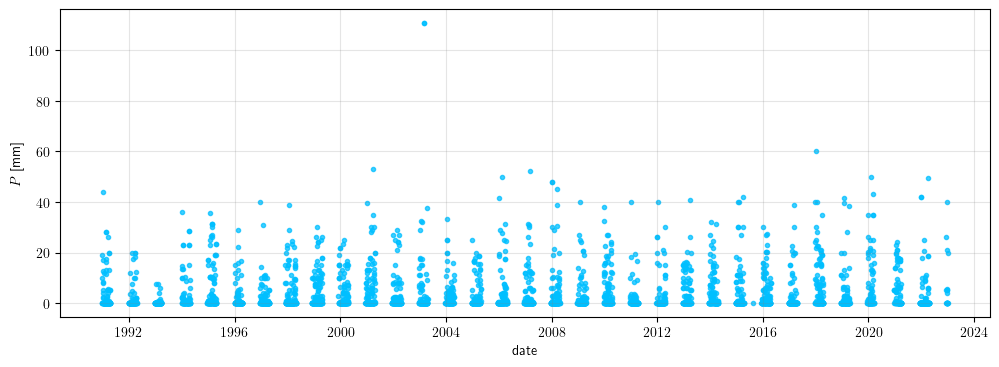

In [866]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(données_pluie['date'], données_pluie["pluie"] ,marker = "." ,color='deepskyblue', alpha = 0.75)
ax.set_ylabel(r'$P$ [mm]')
ax.set_xlabel(r'date')
max_pluie = np.nanmax(données_pluie['pluie'])
date_max = données_pluie[données_pluie['pluie']==max_pluie]['date']
if  len(données_pluie[données_pluie['pluie']==max_pluie].index)>1:
      date_max =  données_pluie[données_pluie['pluie']==max_pluie]['date'].first
      date_max = str((données_pluie[données_pluie['pluie']==max_pluie]['date'].values )[0])[:-10]
      print("Le maximum a été reporté deux fois.")
else:
      date_max = données_pluie[données_pluie['pluie']==max_pluie]['date'].to_string(index = False)
if len(date_max)==10:
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
else:
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%dT%S:%M:%H").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_pluie))   
plt.grid(True, color = 'gray', alpha=0.2)

fig.savefig("Cumul_précipitations(RR)_"+nom_poste+"("+poste_choisi+").pdf",bbox_inches='tight')

### Évolution

Année de début avec données complètes sur toute l'année :  1991
Le cumul annuel de précipitations est 411 mm.


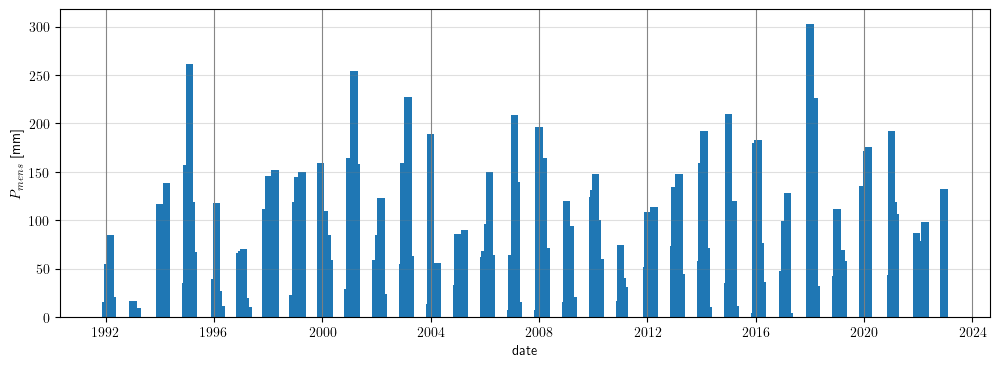

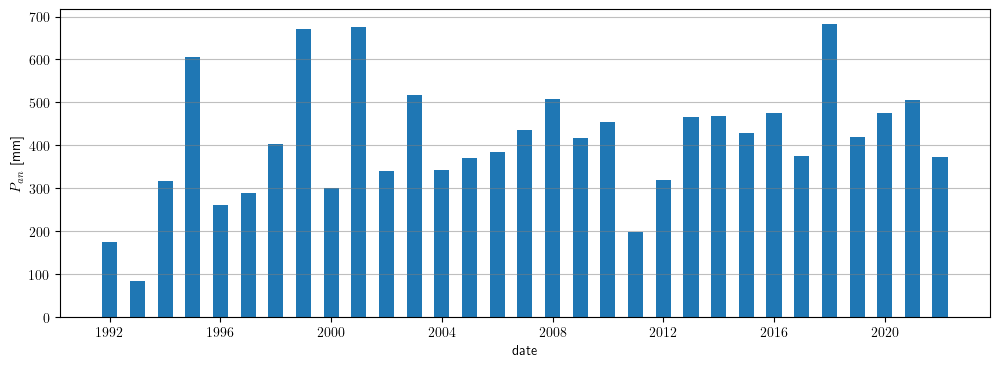

In [867]:
# évolution des cumuls mensuels et annuels

cumul_mensuel = (données_pluie.groupby(by = [données_pluie['date'].dt.month, données_pluie['date'].dt.year]).sum())['pluie'] 
dates_cum     = (données_pluie.groupby(by = [données_pluie['date'].dt.month, données_pluie['date'].dt.year]).first())['date']

cumul_annuel  = ((données_pluie.groupby(by = [données_pluie['date'].dt.year])).sum())['pluie']
dates_an      = (données_pluie.groupby(by = [données_pluie['date'].dt.year]).first())['date']
# Ajuste l'année de départ
véritable_année_début = dates_an[(cumul_annuel>0) & (dates_an.dt.month == 1)].first_valid_index()
print("Année de début avec données complètes sur toute l'année : ", véritable_année_début)
cumul_mensuel = cumul_mensuel[dates_cum.dt.year>véritable_année_début]
dates_cum     = dates_cum[dates_cum.dt.year>véritable_année_début]

cumul_annuel  = cumul_annuel[dates_an.dt.year>véritable_année_début]
dates_an      = dates_an[dates_an.dt.year>véritable_année_début]

#cumul mensuel de précipitation
fig, axs = plt.subplots(figsize=(12, 4))

plt.grid(axis='y', color='gray', alpha=0.25) 
plt.grid(axis='x', color='gray', alpha=0.95)
axs.bar(dates_cum,cumul_mensuel,width=100)
axs.set_ylabel(r'$P_{mens}$  [mm]')
axs.set_xlabel(r'date')
fig.savefig("Evolution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(12, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(dates_an,cumul_annuel,width=200)

axs.set_ylabel(r'$P_{an}$  [mm]')
axs.set_xlabel(r'date')
fig.savefig("Evolution_cumul_annuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

print("Le cumul annuel de précipitations est {:.0f} mm.".format(cumul_annuel.mean()))


Le cumul mensuel de précipitations est de 60 mm


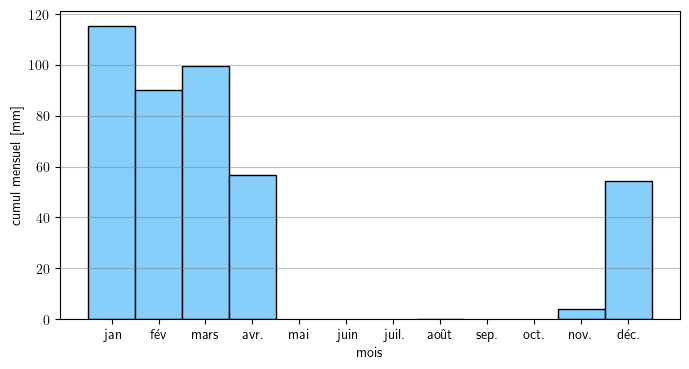

In [868]:
# distribution des cumuls mensuels de précipitation au cours d'une année

moyenne_cumul_mensuel = cumul_mensuel.groupby(by = [cumul_mensuel.index.get_level_values(0)]).mean()

# si tous les mois ne sont renseignés, met des zéros
mois_numérique = np.arange(1,12,1)
différence     = np.setdiff1d(mois_numérique,np.array(moyenne_cumul_mensuel.index.get_level_values(0)))
if np.setdiff1d(mois_numérique,différence).size != 0:
      for mois in différence:
            moyenne_cumul_mensuel.loc[mois]=np.nan
moyenne_cumul_mensuel = moyenne_cumul_mensuel.sort_index(ascending=True)

#cumul annuel de précipitation
fig, axs = plt.subplots(figsize=(8, 4))
plt.grid(axis='y', color='gray', alpha = 0.5)
axs.bar(1+np.arange(12),moyenne_cumul_mensuel,width=1,color='lightskyblue',edgecolor = 'k')

axs.set_ylabel(r'cumul mensuel  [mm]')
axs.set_xlabel(r'mois')
axs.set_xticks(1+np.arange(12), ['jan', 'fév', 'mars','avr.','mai','juin','juil.','août', 'sep.', 'oct.' , 'nov.' ,'déc.'])
fig.savefig("Distribution_cumul_mensuel_precipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

print("Le cumul mensuel de précipitations est de {:.0f} mm".format(moyenne_cumul_mensuel.mean()))

### Analyse des valeurs extrêmes

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,807
Start:                      December 1990      End:                        December 2022
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 33      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

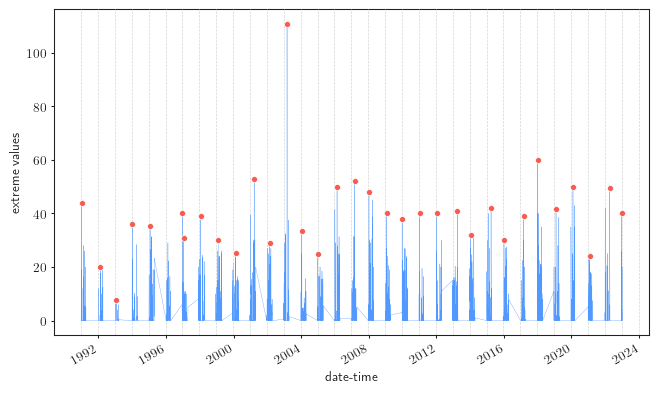

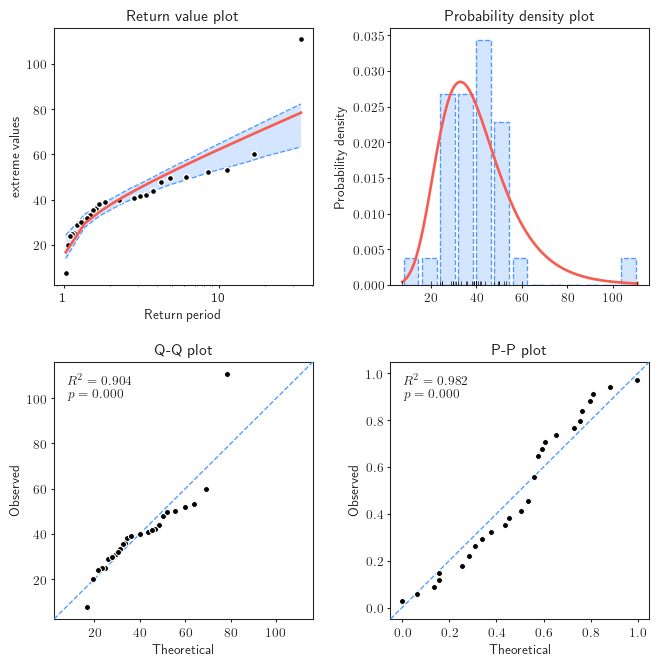

In [874]:
# ******************** EVA ********************************

# Analyse des valeurs extrêmes
série_pluie = pd.Series(np.array(données_pluie['pluie']),index=np.array(données_pluie['date'])).squeeze()
#série_pluie.fillna(method='ffill', inplace=True)

somme_annuelle        = série_pluie.resample('Y').sum()
nombre_années_nulles  = somme_annuelle[somme_annuelle==0].size
if nombre_années_nulles>0:
    dernière_année_mesure = int(str(données_pluie['date'].values[-1] )[0:4])
    dernière_année_nulle  = somme_annuelle[somme_annuelle==0].index[-1]
    if dernière_année_nulle.year == 2021:
        série2 = série_pluie[série_pluie.index<dernière_année_nulle]
        print(colored("Je suspecte qu'à cause de la covid, l'année 2021 est incomplète. Je m'arrête en 2020", 'red')
           )
    else:
        if nombre_années_nulles == 1:
            print("Il y a en tout une année nulle.") 
            print("Il faut commencer à partir de {:d} !".format(dernière_année_nulle.year+1))
            série2 = série_pluie[série_pluie.index>dernière_année_nulle]
            
        elif nombre_années_nulles > 1:
            série2 = série_pluie[série_pluie.index>dernière_année_nulle]
            print("Il y a en tout {:d} années nulles. Il faut commencer à partir de {:d} !"
              .format(nombre_années_nulles, dernière_année_nulle.year+1))    
            print(colored("J'ai pris une période plus courte",'red'))

else:
            série2 = série_pluie  
     
model = EVA(série2)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


Text(0, 0.5, '$P$ [mm]')

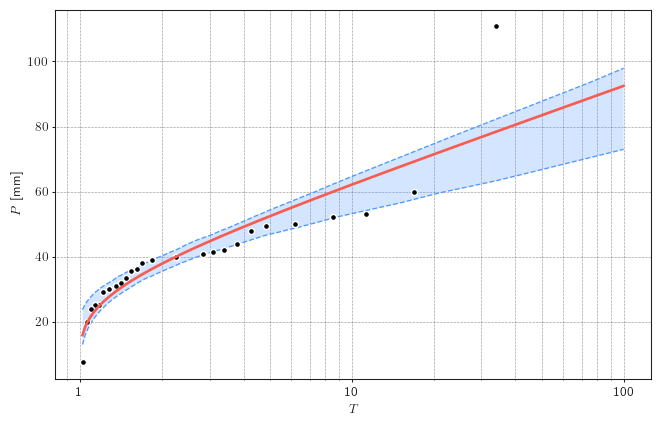

In [875]:
fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$")
axes.set_ylabel(r"$P$ [mm]")

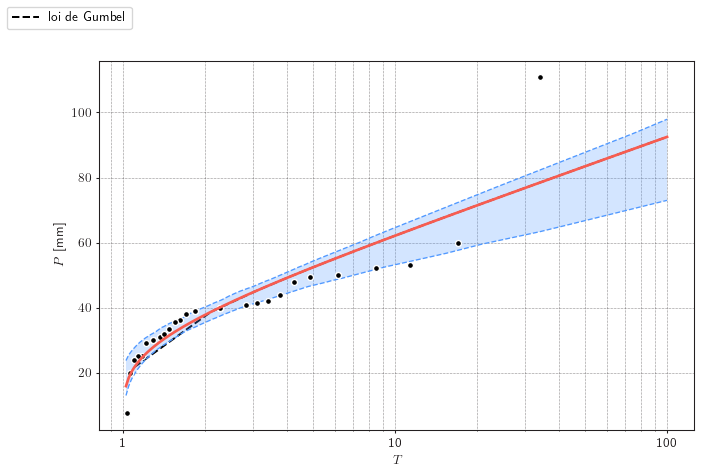

In [876]:
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_précipitations_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig


In [877]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


return value   lower ci   upper ci
return period                                    
10.0              62.122883  54.665138  65.517882
30.0              76.774219  65.028193  81.744668
100.0             92.484132  76.615513  99.339332

## Distribution des températures

Le maximum a été atteint le 13/03/2020 avec une température de 17.1 °C.
Le minimum a été atteint le 29/01/2004 avec une température de -11.0 °C.


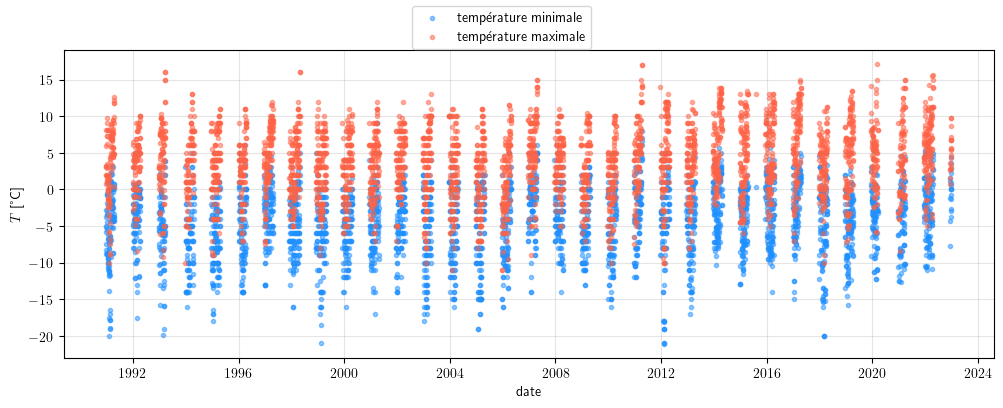

In [878]:
# distribution temporelle des température
fig, ax = plt.subplots(figsize=(12,4))

ax.set_ylabel(r'$T$ [°C]')
ax.set_xlabel(r'date')
# comme il peut y avoir plusieurs multiples on choisit la première occurrence
date_max = données_pluie[données_pluie.index  == données_pluie[données_pluie['TX']==np.nanmax(données_pluie['TX'])].first_valid_index()]['date'].to_string(index = False)
date_min = données_pluie[données_pluie.index  == données_pluie[données_pluie['TX']==np.nanmin(données_pluie['TX'])].first_valid_index()]['date'].to_string(index = False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
date_min = datetime.datetime.strptime(date_min ,"%Y-%m-%d").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec une température de {:.1f} °C.".format(np.nanmax(données_pluie["TX"]))  )
print("Le minimum a été atteint le "+date_min+" avec une température de {:.1f} °C.".format(np.nanmin(données_pluie["TX"]))  )
ax.scatter(données_pluie['date'], données_pluie["TN"] ,marker = "." ,color='dodgerblue', alpha = 0.5,label = "température minimale")
ax.scatter(données_pluie['date'], données_pluie["TX"] ,marker = "." ,color='tomato', alpha = 0.5,label = "température maximale")
fig.legend(loc='outside upper center')
plt.grid(True, color = 'gray', alpha=0.2)

On observe un accroissement de température de 5.9 °C par siècle.


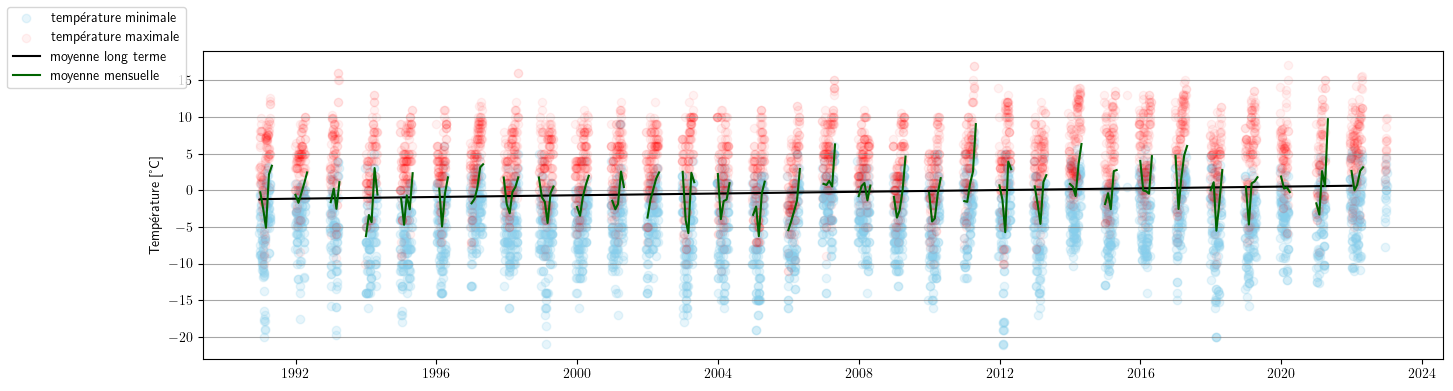

In [879]:
# parfois la série TM commence après TN et TX:
if np.isnan(données_pluie["TM"].values [0]): données_pluie["TM"] = (données_pluie["TX"]+données_pluie["TN"])/2
série_température = pd.Series(np.array(données_pluie["TM"]),index=np.array(données_pluie["date"])).squeeze()
série_température.resample('M').mean()

température_annuelle  = np.array(données_pluie.groupby(by = [données_pluie['date'].dt.year])['TM'].mean())
dates_température     = données_pluie.groupby(by = [données_pluie['date'].dt.year])['date'].first()
dates_température_an  = np.array(dates_température.dt.year)
filtre = ~np.isnan(température_annuelle) # enlève les valeurs NaN
slope, intercept, r_value, p_value, std_err = stats.linregress(dates_température_an[filtre], température_annuelle[filtre])
trendline = intercept + slope*dates_température_an[filtre]

fig, axs = plt.subplots(figsize=(16, 4))
axs.scatter(données_pluie["date"],données_pluie["TN"],color = "skyblue", alpha = 0.2, label = "température minimale")
axs.scatter(données_pluie["date"],données_pluie["TX"],color = "red", alpha = 0.05, label = "température maximale")

axs.set_ylabel("Température [°C]")
axs.grid(axis='y', color='grey', alpha = 0.7)
axs.plot(dates_température[filtre], trendline, color = 'black', label = "moyenne long terme")


axs.plot(série_température.resample('M').mean(), color = 'darkgreen', label = "moyenne mensuelle")
fig.legend(loc = "outside upper left")
fig.savefig("Evolution_température_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
print("On observe un accroissement de température de {:.1f} °C par siècle.".format(100*slope))



/tmp/ipykernel_22764/1519149160.py:12: RuntimeWarning:

Mean of empty slice



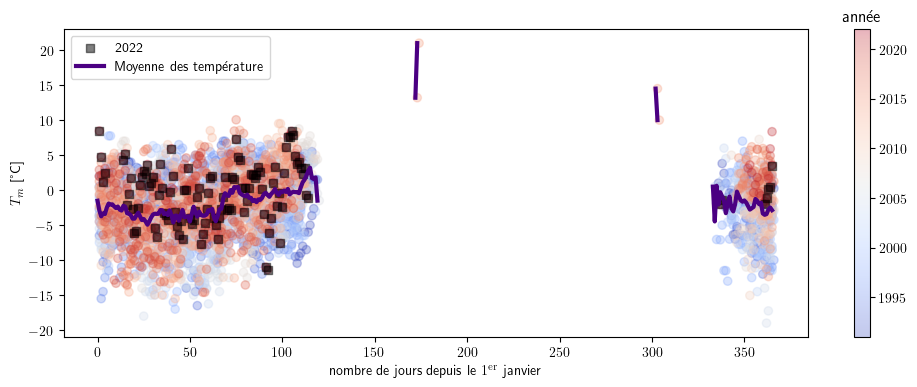

In [792]:
# Evolution moyenne de la température au fil de la saison
jour_civil = np.array(données_pluie['date'].dt.dayofyear)

année_référence = 2022
jour_civil_référence  = np.array(données_pluie[données_pluie['date'].dt.year == année_référence]['date'].dt.dayofyear)
température_référence = np.array(données_pluie[données_pluie['date'].dt.year == année_référence]['TM'])


valT = np.array(données_pluie["TM"])
moyenne_température = []
for i in range(1,367):
    moyenne_température.append(np.nanmean(valT[jour_civil == i] ))  

fig, axs = plt.subplots(figsize=(12, 4))
diag_TM = axs.scatter(jour_civil,valT, alpha = 0.3, c=np.array(données_pluie['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_référence,température_référence, alpha = 0.5, marker = "s", color = "black", label = str(année_référence) )
axs.plot(moyenne_température,color = "indigo", linewidth=3.0, label = "Moyenne des température")
cbar = fig.colorbar(diag_TM)
cbar.ax.set_title('année', rotation=0)
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper left')


fig.savefig("Evolution_annuelle_Température_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')


## Neige

In [880]:
if existe_neige:
      # Nettoyage du fichier en enlevant les valeurs NaN
      données_neige = données_neige[données_neige['date']>=date_début]

      #données_neige.set_index('date', inplace=True)
      #données_neige.fillna(method='ffill', inplace=True)
      #données_neige.fillna(value=0, inplace=True)
      données_neige.info()
else: 
      print("Pas de données relatives aux chutes journalières de neige...")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3795 entries, 640422 to 644216
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3795 non-null   datetime64[ns]
 1   neige   3236 non-null   float64       
 2   HN      3697 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 118.6 KB


Le maximum a été atteinte le 18/01/1998 avec un cumul journalier de 67.0 cm.


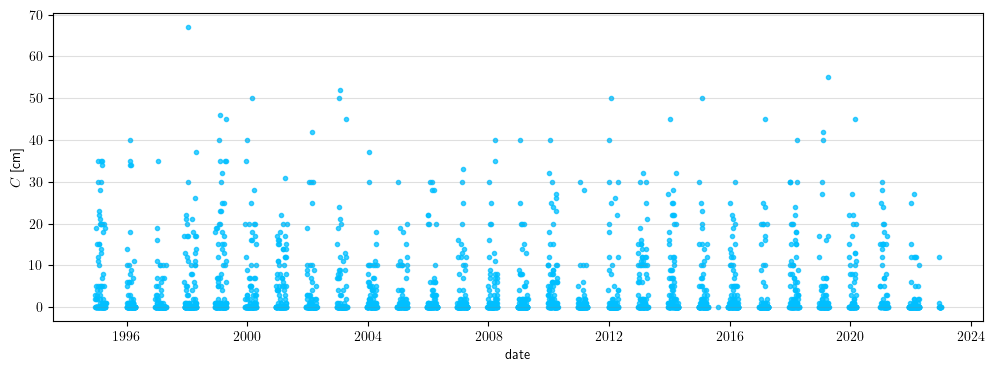

In [881]:
if existe_neige:
      # distribution temporelle des distributions
      fig, ax = plt.subplots(figsize=(12,4))
      ax.scatter(données_neige['date'], données_neige["neige"] ,marker = "." ,color='deepskyblue', alpha = 0.75)
      ax.set_ylabel(r'$C$ [cm]')
      ax.set_xlabel(r'date')
      plt.grid(axis="y", color = 'gray', alpha = 0.25)
      date_max = données_neige[données_neige['neige']==np.nanmax(données_neige['neige'])]['date'].to_string(index = False)
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
      print("Le maximum a été atteinte le "+date_max+" avec un cumul journalier de {:.1f} cm.".format(np.nanmax(données_neige["neige"]))  )
      fig.savefig("Evolution_annuelle_Chute_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

### Évolution saisonnière

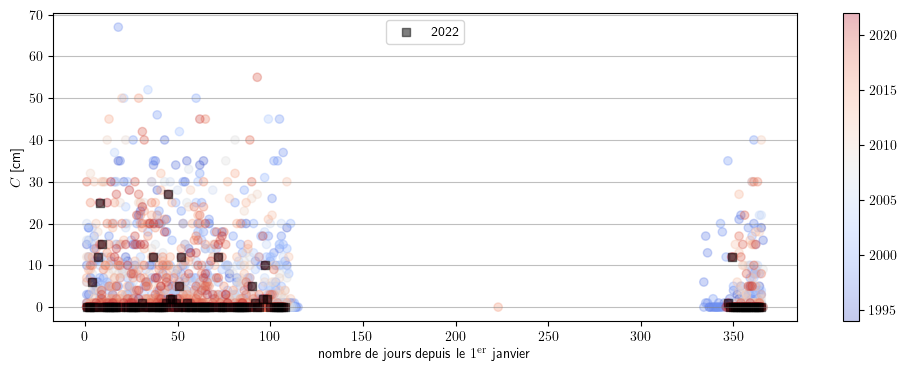

In [882]:
if existe_neige:
      jour_civil = np.array(données_neige['date'].dt.dayofyear)

      année_référence = 2022
      jour_civil_référence  = np.array(données_neige[données_neige['date'].dt.year == année_référence]['date'].dt.dayofyear)
      chute_référence = np.array(données_neige[données_neige['date'].dt.year == année_référence]['neige'])
      valN = np.array(données_neige["neige"])
 
      fig, axs = plt.subplots(figsize=(12, 4))
      diag_TN = axs.scatter(jour_civil,valN, alpha = 0.3, c=np.array(données_neige['date'].dt.year),cmap = 'coolwarm')
      axs.scatter( jour_civil_référence,chute_référence, alpha = 0.5, marker = "s", color = "black", label = str(année_référence) )
      plt.grid(axis="y", color = 'gray', alpha = 0.5)
      fig.colorbar(diag_TN)
      axs.set_ylabel(r'$C$ [cm]')
      axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
      axs.legend(loc='upper center')


### Évolution au fil des ans

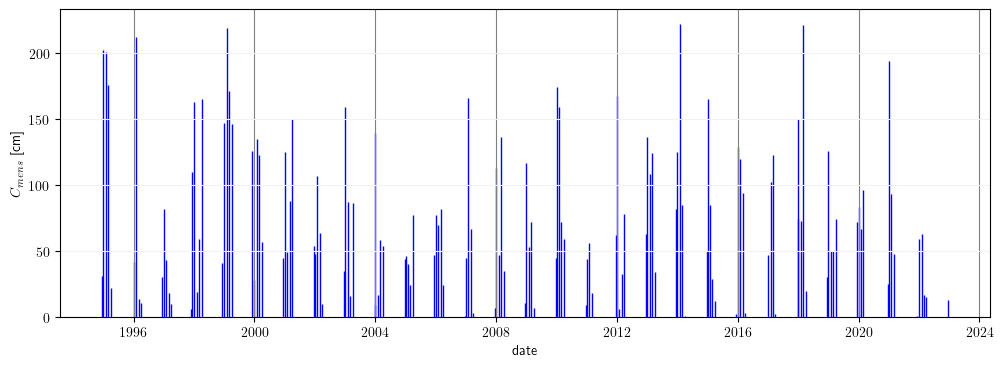

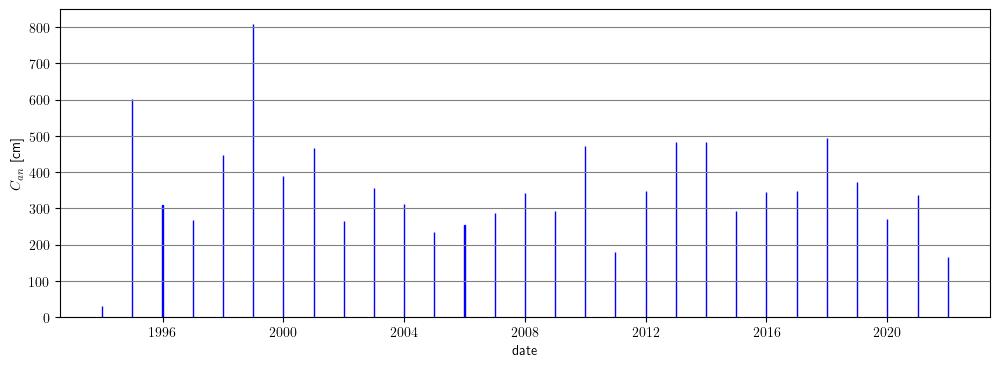

In [883]:
if existe_neige:
      cumul_mensuel = données_neige.groupby(by = [données_neige['date'].dt.month, données_neige['date'].dt.year])['neige'] .sum()
      dates_cum=données_neige.groupby(by = [données_neige['date'].dt.month, données_neige['date'].dt.year])['date'].first()

      cumul_annuel = données_neige.groupby(by = [données_neige['date'].dt.year])['neige'] .sum()
      dates_an=données_neige.groupby(by = [ données_neige['date'].dt.year])['date'].first()

      #cumul mensuel de neige
      
      fig, axs = plt.subplots(figsize=(12, 4))

      axs.bar(dates_cum.values ,cumul_mensuel.values ,width=31 ,ec='blue' )
      plt.grid(axis='y', color='0.95')
      plt.grid(axis='x', color='gray')
      axs.set_ylabel(r'$C_{mens}$  [cm]')
      axs.set_xlabel(r'date')

      fig.savefig("Evolution_cumul_mensuel_poste_"+poste_choisi+".pdf",bbox_inches='tight')

      #cumul annuel de neige
      filtre = np.nonzero(cumul_annuel.values)
      fig, axs = plt.subplots(figsize=(12, 4))
      axs.bar(dates_an.values[filtre],cumul_annuel.values[filtre],ec='blue')
      plt.grid(axis='y', color='0.5')
      axs.set_ylabel(r'$C_{an}$  [cm]')
      axs.set_xlabel(r'date')

      fig.savefig("Evolution_cumul_annuel_"+nom_commune+"("+poste_choisi+").pdf",bbox_inches='tight')

### Valeurs extrêmes

/home/ancey/anaconda3/lib/python3.9/site-packages/pyextremes/eva.py:131: RuntimeWarning:

145 Null values found in `data` - removing invalid entries



                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,029
Start:                       January 1995      End:                        December 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 26      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

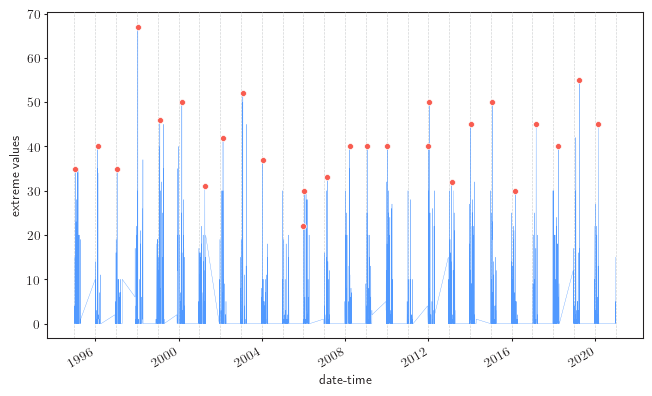

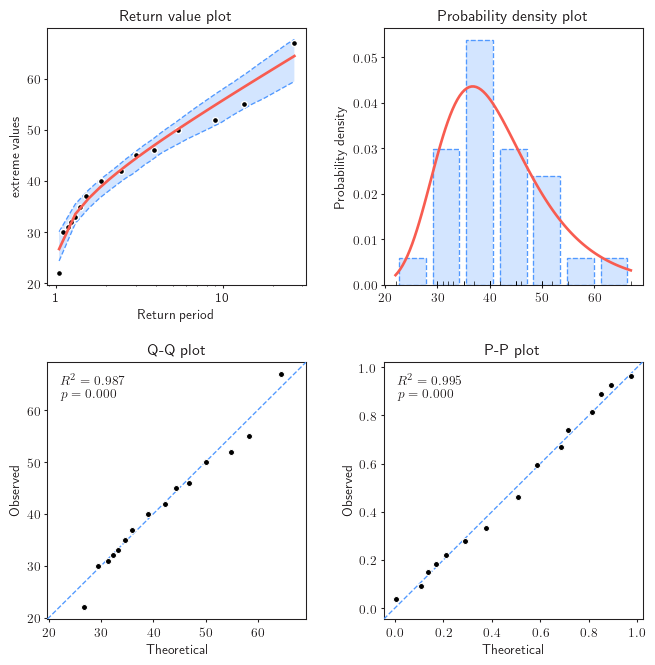

In [884]:
# Analyse des valeurs extrêmes
série_chute = pd.Series(np.array(données_neige['neige']),index=np.array(données_neige['date'])).squeeze()
# Quand il y a des années avec des valeurs nulles
série_chute2 = série_chute["1995-01-01":"2020-12-31"]
model = EVA(série_chute2)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


Text(0, 0.5, '$C$ [cm]')

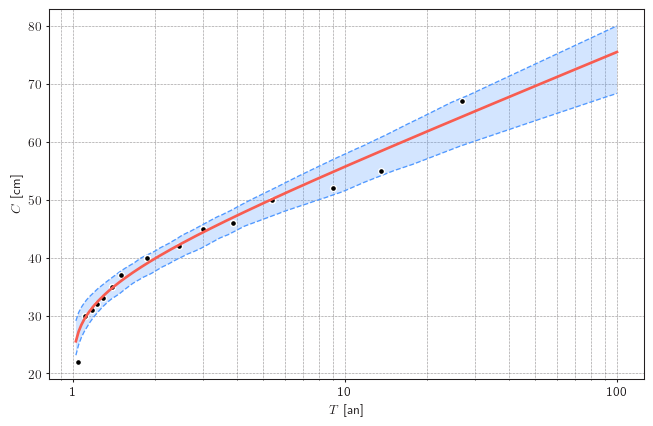

In [885]:
fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"$C$ [cm]")


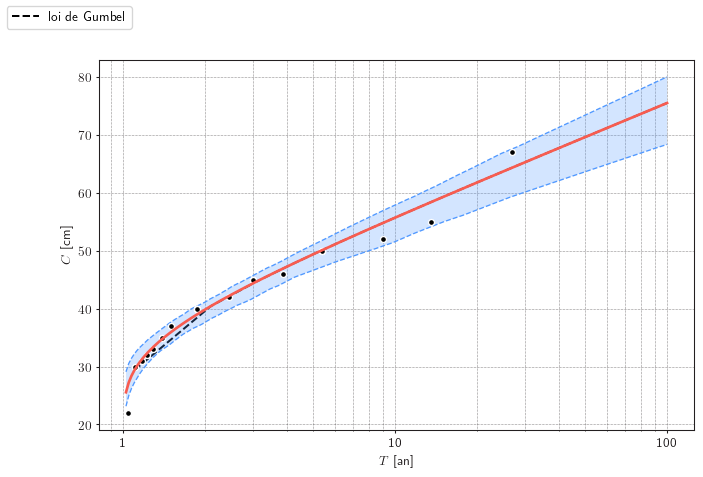

In [886]:

calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_chutes_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig


In [887]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


return value   lower ci   upper ci
return period                                    
10.0              55.736848  51.342632  58.076272
30.0              65.294758  58.886993  68.573147
100.0             75.543238  66.822837  79.785013

## Épaisseur du manteau neigeux

### Évolution au fil des années

Le maximum a été atteint le 09/03/1995 avec une hauteur de 236 cm.


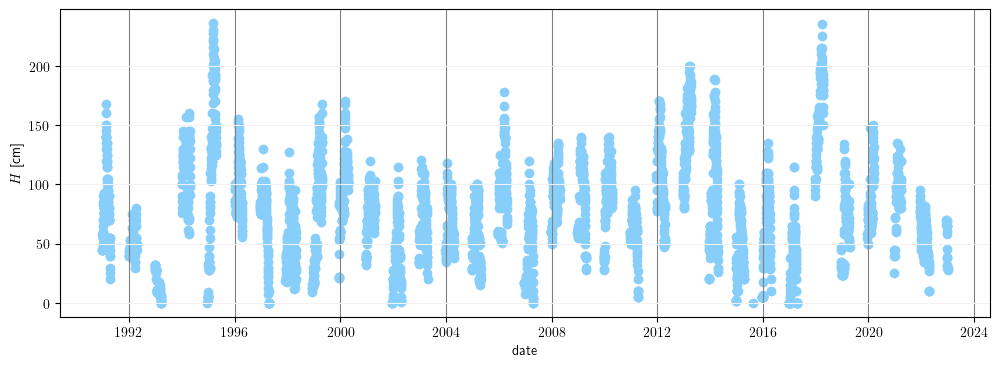

In [888]:
if existe_HN:
      # J'enlève les années nulles
      somme_annuelle = pd.Series(np.array(données_neige["HN"]), index = np.array(données_neige["date"])).resample('Y').sum()
      nombre_années_nulles = somme_annuelle[somme_annuelle==0].size
      if nombre_années_nulles == 1:
            print("Il y a en tout une année nulle.") 
            dernière_année_nulle = somme_annuelle[somme_annuelle==0].index[-1]
            print("Il faut commencer à partir de {:d} ?".format(dernière_année_nulle.year+1))  
            données_neige["HN"]=données_neige[données_neige['date']>dernière_année_nulle]["HN"]
      elif nombre_années_nulles > 1: 
            dernière_année_nulle = somme_annuelle[somme_annuelle==0].index[-1]  
            print(colored("J'ai pris une période plus courte",'red'))
            print("Il y a en tout {:d} années nulles. Il faut commencer à partir de {:d} !".format(nombre_années_nulles, dernière_année_nulle.year+1))
            données_neige["HN"]=données_neige[données_neige['date']>dernière_année_nulle]["HN"]    
      # distribution temporelle des hauteurs du manteux neigeux
      date_max = données_neige[données_neige['HN']==np.nanmax(données_neige['HN'])]['date'].to_string(index = False)
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")


      fig, axs = plt.subplots(figsize=(12, 4))
      axs.scatter(données_neige['date'],données_neige["HN"], color = 'lightskyblue')
      plt.grid(axis='y', color='0.95')
      plt.grid(axis='x', color='gray')
      axs.set_ylabel(r'$H$  [cm]')
      axs.set_xlabel(r'date')
      print("Le maximum a été atteint le "+date_max+" avec une hauteur de {:.0f} cm.".format(np.nanmax(données_neige["HN"]))  )

      fig.savefig("Evolution_annuelle_épaisseur_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')

### Évolution au fil de la saison

/tmp/ipykernel_22764/578461455.py:15: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_22764/578461455.py:16: RuntimeWarning:

All-NaN slice encountered

/tmp/ipykernel_22764/578461455.py:17: RuntimeWarning:

All-NaN slice encountered



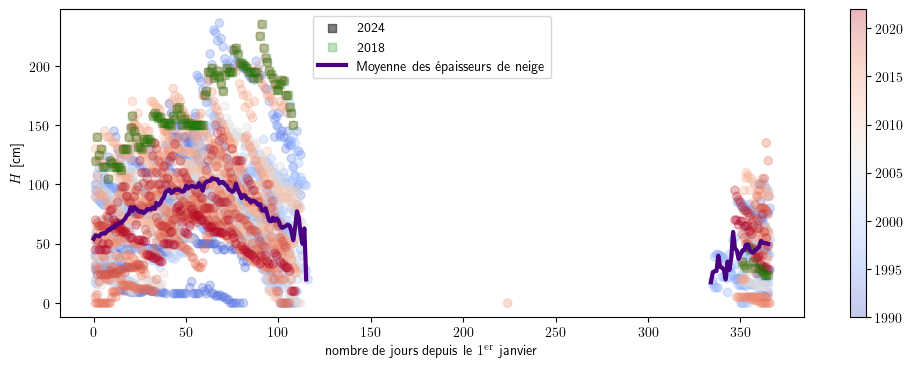

In [889]:
if existe_HN:
    jour_civil       = np.array(données_neige['date'].dt.dayofyear)
    jour_civil_2018  = np.array(données_neige[données_neige['date'].dt.year == 2018]['date'].dt.dayofyear)
    hauteur_2018     = np.array(données_neige[données_neige['date'].dt.year == 2018]['HN'])
 
    jour_civil_2008  = np.array(données_neige[données_neige['date'].dt.year == 2008]['date'].dt.dayofyear)
    hauteur_2008     = np.array(données_neige[données_neige['date'].dt.year == 2008]['HN'])

    valH = np.array(données_neige["HN"])
    moyenne_hauteur = []
    max_hauteur = []
    min_hauteur = []
    for i in range(1,367):
        if valH[jour_civil == i].size > 0:
            moyenne_hauteur.append(np.nanmean(valH[jour_civil == i] ))
            min_hauteur.append(np.nanmin(valH[jour_civil == i] ))
            max_hauteur.append(np.nanmax(valH[jour_civil == i] ))
        else:
            moyenne_hauteur.append(np.nan)
            min_hauteur.append(np.nan)
            max_hauteur.append(np.nan) 

    fig, axs = plt.subplots(figsize=(12, 4))
    diag_hauteur = axs.scatter(jour_civil,valH, alpha = 0.3, c=np.array(données_neige['date'].dt.year),cmap = 'coolwarm')
    axs.scatter(jour_civil_2024, hauteur_2024, alpha = 0.5, marker = "s", color = "black", label = "2024" )
    axs.scatter(jour_civil_2018, hauteur_2018, alpha = 0.25, marker = "s", color = "green", label = "2018" )
    axs.plot(moyenne_hauteur,color = "indigo", linewidth=3.0, label = "Moyenne des épaisseurs de neige")
    fig.colorbar(diag_hauteur)
    axs.set_ylabel(r'$H$ [cm]')
    axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
    axs.legend(loc='upper center')
else:
    print("Pas de données relatives aux épaisseurs du manteau neigeux")

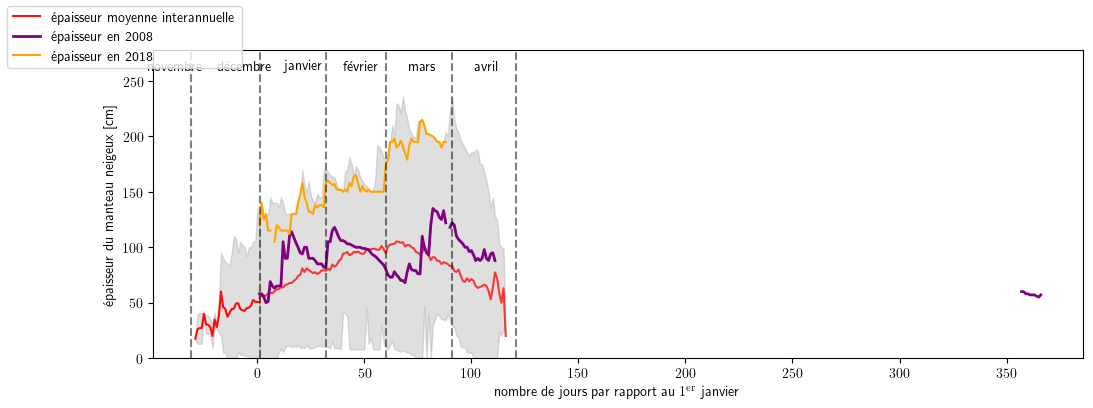

In [890]:
# évolution du manteau neigeux
date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin    = fin_saison - début_année
delta_début  = fin_année - début_saison
jour_d       = np.array(range(366))-363
jour         = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.25)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.25)

axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "épaisseur moyenne interannuelle")
axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] , color ='red',alpha = 0.75)

axs.plot(jour_civil_2008[0:delta_fin.days],hauteur_2008[0:delta_fin.days] , color ='purple',alpha = 1,linewidth = 2, label = "épaisseur en 2008")

axs.plot(jour_civil_2018[0:(delta_fin.days-47)],hauteur_2018[0:(delta_fin.days-47)] , color ='Orange',alpha = 1, label = "épaisseur en 2018")

limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+30))
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,260,mois_nom[i])
fig.legend(loc='outside upper left')
axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')
plt.savefig("Evolution_manteau_neigeux_"+nom_commune+"("+poste_choisi+").pdf",bbox_inches='tight')


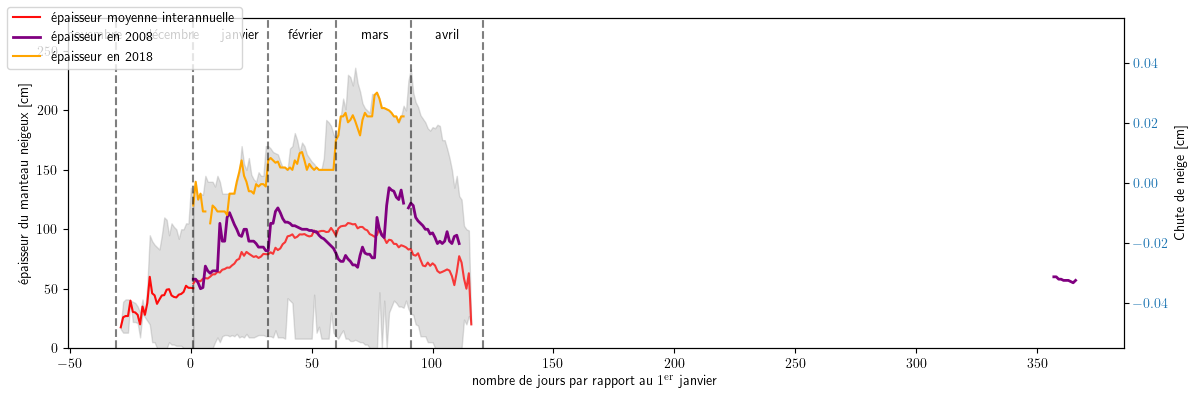

In [891]:
# Détermination des chutes de neige de la saison
saison_2024 = données_neige[(données_neige['date'].dt.year == 2024 )|(( données_neige['date'].dt.year ==2023) & ( données_neige['date'].dt.month >10) )]
chutes_2024 = np.array(saison_2024['neige'])
dates_2024 = saison_2024['date']-datetime.datetime.strptime('31/12/2023', date_format)
dates_2024 = np.array(dates_2024.dt.days)


ax2 = axs.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Chute de neige [cm]' )   
ax2.bar(dates_2024, chutes_2024, color=color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  

fig.savefig("Evolution_manteau_neigeux+chutes_neige_"+nom_commune+"("+poste_choisi+").pdf",bbox_inches='tight')
fig

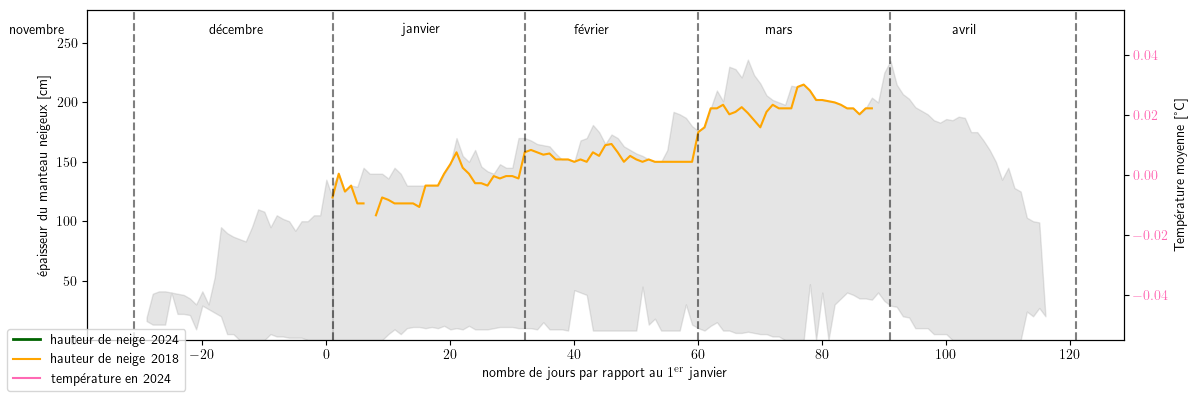

In [892]:
 # Détermination des chutes de neige de la saison
saison_Température_2024 = données_pluie[(données_pluie['date'].dt.year == 2024 )|(( données_pluie['date'].dt.year ==2023) & ( données_pluie['date'].dt.month >10) )]
Température_2024 = np.array(saison_Température_2024['TM'])
saison_Température_2024 = saison_Température_2024['date']-datetime.datetime.strptime('31/12/2023', date_format)
saison_Température_2024 = np.array(saison_Température_2024.dt.days)



date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin = fin_saison - début_année
delta_début = fin_année - début_saison
jour_d =np.array(range(366))-363
jour = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.2)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.2)

#axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "moyenne")
#axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] ,'--', color ='red',alpha = 0.5)

axs.plot(jour_civil_2024[0:delta_fin.days],hauteur_2024[0:delta_fin.days] , color ='darkgreen',alpha = 1,linewidth = 2, label = "hauteur de neige 2024")

axs.plot(jour_civil_2018[0:(delta_fin.days-47)],hauteur_2018[0:(delta_fin.days-47)] , color ='Orange',alpha = 1, label = "hauteur de neige 2018")

limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+30))


# grille des mois
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y + 10,mois_nom[i])

axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')

ax2 = axs.twinx()   

# tracé des températures
color = 'hotpink'
ax2.set_ylabel('Température moyenne [°C]' )   
ax2.plot(saison_Température_2024, Température_2024, color=color, alpha = 1, linewidth = 1.5, label = "température en 2024")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='outside lower left')
fig.tight_layout()   
fig.savefig("Evolution_température+chutes_neige_"+nom_commune+"("+poste_choisi+").pdf",bbox_inches='tight')

### Valeurs extrêmes

/home/ancey/anaconda3/lib/python3.9/site-packages/pyextremes/eva.py:131: RuntimeWarning:

98 Null values found in `data` - removing invalid entries



Text(0, 0.5, '$H$ [cm]')

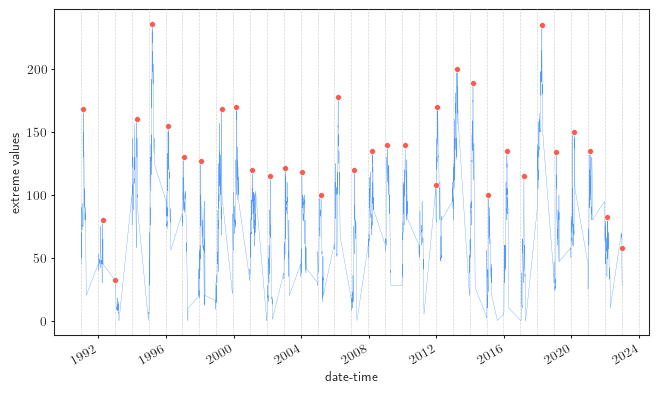

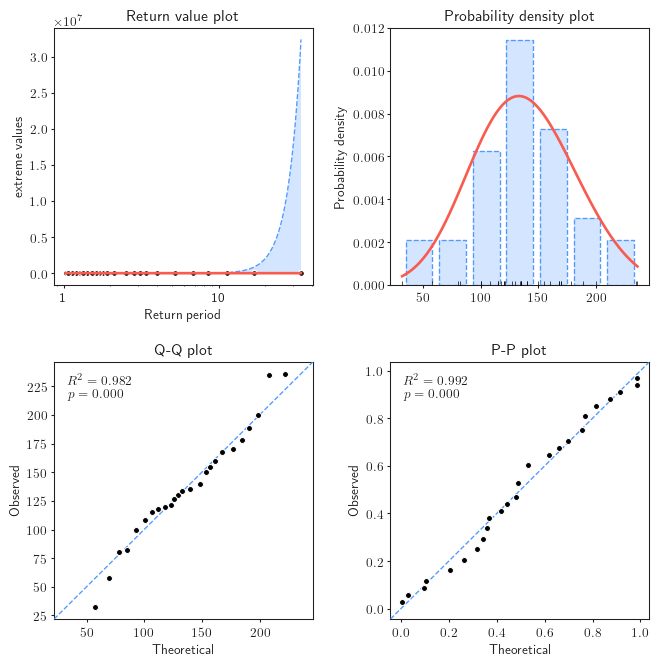

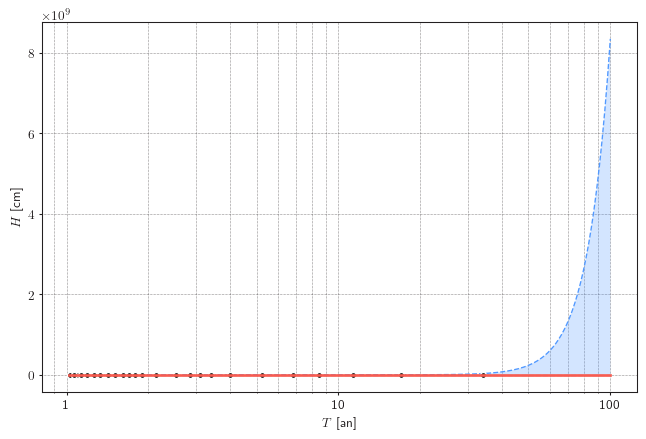

In [893]:
# Analyse des valeurs extrêmes
série_hauteur = pd.Series(np.array(données_neige['HN']),index=np.array(données_neige['date'])).squeeze()
#série_pluie.fillna(method='ffill', inplace=True)
model = EVA(série_hauteur)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"$H$ [cm]")


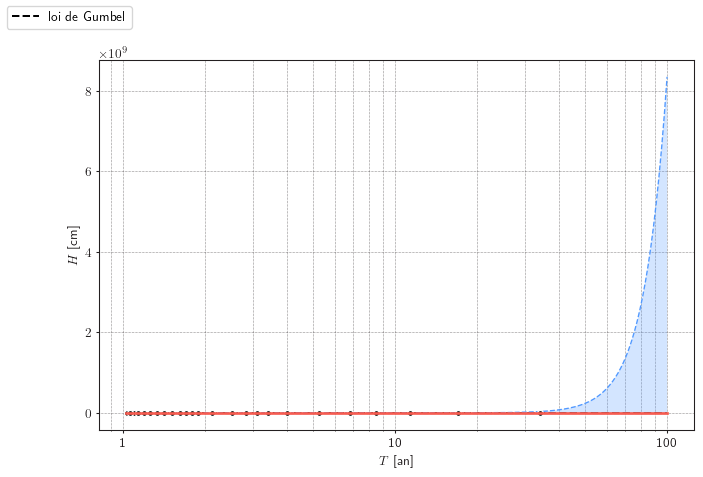

In [894]:
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_Epaisseur_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig

In [895]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary

return value    lower ci      upper ci
return period                                        
10.0             195.495329  184.552825  9.638563e+04
30.0             219.789952  205.716445  3.748002e+07
100.0            239.225707  225.182824  1.869232e+10

In [896]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               3,697
Start:                      December 1990      End:                        December 2022
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 33      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

## Chutes de neige sur trois jours

In [897]:
série_chute = pd.Series(np.array(données_neige['neige']),index=np.array(données_neige['date'])).squeeze()

In [898]:
série_trois_jours = série_chute.rolling(3, win_type='boxcar', center=True).sum()
print("Le cumul maximum sur trois jours a été de {:d} cm.".format(int(np.nanmax(série_trois_jours))))

somme_annuelle = série_trois_jours.resample('Y').sum()
nombre_années_nulles = somme_annuelle[somme_annuelle==0].size
dernière_année_nulle = somme_annuelle[somme_annuelle==0].index[-1]
if dernière_année_nulle.year == 2021:
    série3 = série_trois_jours[série_trois_jours.index<dernière_année_nulle]
    print(colored("Je suspecte qu'à cause de la covid, l'année 2021 est incomplète. Je m'arrête en 2020", 'red')
           )
else:
    if nombre_années_nulles == 1:
        print("Il y a en tout une année nulle.") 
    
        série3 = série_trois_jours[série_trois_jours.index>dernière_année_nulle]
    elif nombre_années_nulles > 1:
        print("Il y a en tout {:d} années nulles. Il faut commencer à partir de {:d} !".format(nombre_années_nulles, dernière_année_nulle.year+1))    
        print(colored("J'ai pris une période plus courte",'red'))
        dernière_année_nulle = somme_annuelle[somme_annuelle==0].index[-1]
        série3 = série_trois_jours[série_trois_jours.index>dernière_année_nulle]
    else:
        série3 = série_trois_jours  

Le cumul maximum sur trois jours a été de 101 cm.
Il y a en tout 4 années nulles. Il faut commencer à partir de 1994 !
J'ai pris une période plus courte


### EVA

/home/ancey/anaconda3/lib/python3.9/site-packages/pyextremes/eva.py:131: RuntimeWarning:

583 Null values found in `data` - removing invalid entries



Text(0, 0.5, '$C_3$ [cm]')

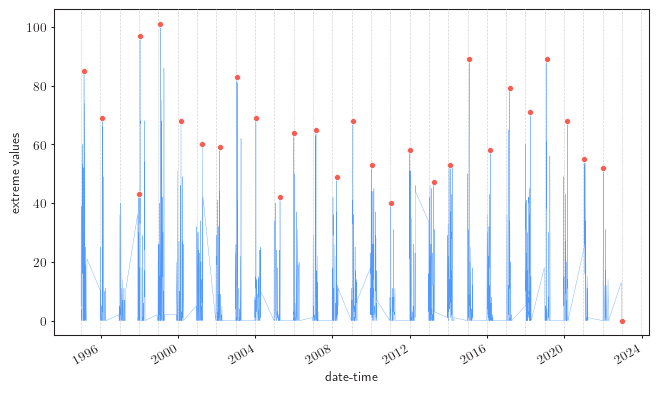

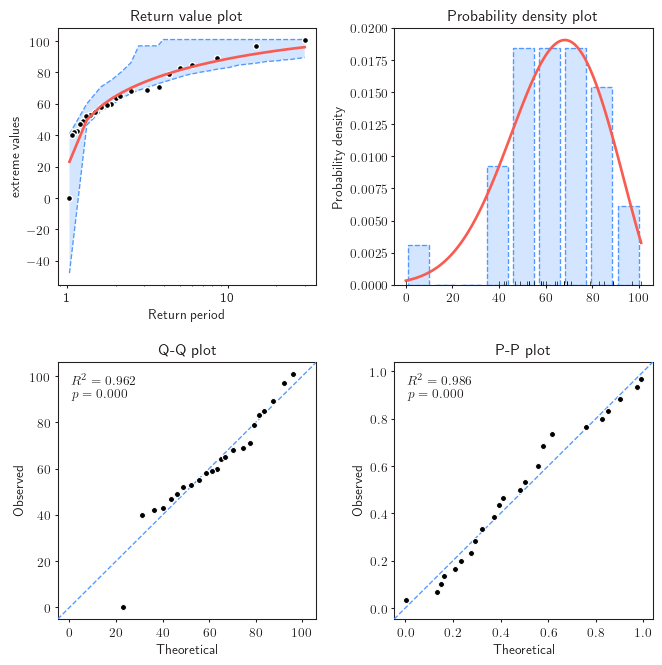

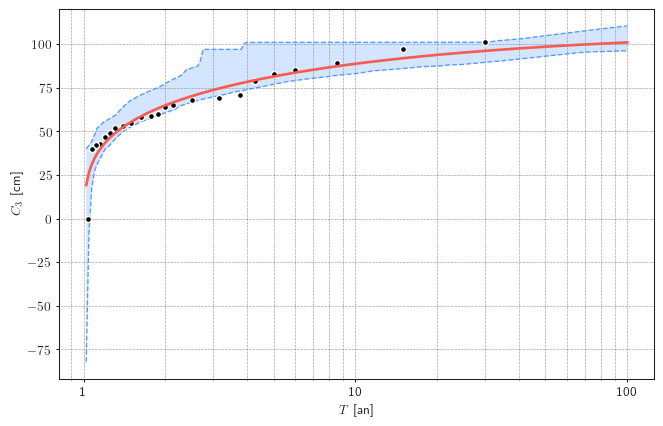

In [899]:
#  ****************** EVA ****************** 

# Analyse des valeurs extrêmes
 
#série_pluie.fillna(method='ffill', inplace=True)
model = EVA(série3)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model


fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"$C_3$ [cm]")

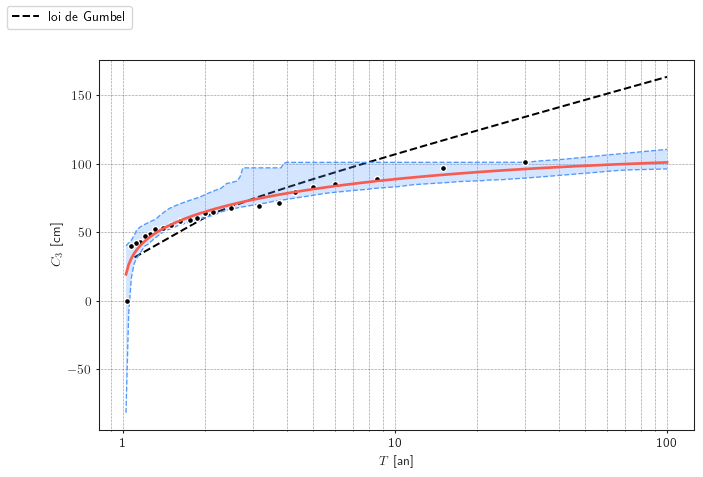

In [900]:
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_trois_jours_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')
fig

In [901]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.7,
    n_samples=1000,
)
summary


return value   lower ci    upper ci
return period                                     
10.0              88.740403  83.218505   96.999995
30.0              96.155212  91.654549  101.000000
100.0            100.983212  96.379230  112.007368

In [902]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                               2,921
Start:                      December 1994      End:                        December 2022
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 29      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

## épisodes de précipitations

In [903]:
# remplace nan par 0
valeurs_neige = np.nan_to_num(np.array(données_neige['neige']))
 
série_chute = pd.Series(valeurs_neige,index=np.array(données_neige['date'])).squeeze()

zneige = valeurs_neige !=0
### points de bascule
zneige[1:] ^= zneige[:-1]
#liste des épisodes
liste_épisode=np.split(valeurs_neige, *np.where(zneige))[1::2]

# cherche où est l'épisode
def is_sub_array(original, subarray):
    first_match = np.where(original == subarray[0])
    if len(first_match) == 0:
        return -1
    else:
        for match in first_match[0]:
            cut_original = original[match:match + len(subarray)]
            if (cut_original == subarray).all():
                    return match
             



In [904]:
### scinde valeurs_neige en épisodes
liste_épisode = np.split(valeurs_neige, *np.where(zneige))[1::2]
liste_épisode = np.asarray(liste_épisode, dtype="object") # c'est un tableau de tableaux de taille différente
# cumul de neoige
total_épisode = np.array(list(map((lambda x: np.sum(x)),liste_épisode )))
max_épisode = max(total_épisode )
indice_max  = (np.where(total_épisode==max_épisode)[0] )[0]
épisode_max = liste_épisode[indice_max]
durée_max   = len(épisode_max) 
indice_épisode = is_sub_array(valeurs_neige, épisode_max )
if indice_épisode == 0:
      print(colored("Il y a une erreur, je ne trouve pas la position de l'épisode max.",'red'))
else:
      date_épisode = np.array(données_neige['date'])[indice_épisode]
      date_épisode = datetime.datetime.strptime(str(date_épisode )[0:10] ,"%Y-%m-%d").strftime("%d/%m/%Y")
      print("Le cumul maximal est de {:.0f} cm. C'est un épisode qui a duré {:d} jours et qui commencé le {:s}."
            .format(max_épisode,durée_max,date_épisode ))

 

Le cumul maximal est de 165 cm. C'est un épisode qui a duré 14 jours et qui commencé le 05/04/1998.


In [905]:
seuil_épisode = 100
sélection_épisode = liste_épisode[ total_épisode>seuil_épisode   ] 
sélection_épisode = np.asarray(sélection_épisode, dtype="object") # c'est un tableau de tableaux de taille différente
classement_épisode = []
print("Il y a {:.0f} épisodes dont le cumul dépasse {:.0f} cm :".format(len(sélection_épisode), seuil_épisode))
for i in range(len(sélection_épisode)):
      
      ép = sélection_épisode[i]
      code_sélection = is_sub_array(valeurs_neige, ép)
      total_ép = sum(sélection_épisode[i])

      
      if code_sélection>0:
            date_épisode =  série_chute.iloc[[code_sélection] ].index 
            date_épisode = (date_épisode.strftime("%d/%m/%Y")) [0].strip()
            print("* date :",date_épisode," -- Durée : ", len(ép)," j-- Total = ", total_ép)
            classement_épisode.append([date_épisode, total_ép,len(ép) ])
      else: print("erreur our i =", i, " code =", code_sélection )


Il y a 7 épisodes dont le cumul dépasse 100 cm :
* date : 21/02/1995  -- Durée :  6  j-- Total =  117.0
* date : 02/03/1995  -- Durée :  5  j-- Total =  101.0
* date : 05/04/1998  -- Durée :  14  j-- Total =  165.0
* date : 05/02/1999  -- Durée :  5  j-- Total =  131.0
* date : 12/04/1999  -- Durée :  7  j-- Total =  134.0
* date : 28/01/2015  -- Durée :  5  j-- Total =  127.0
* date : 26/01/2019  -- Durée :  8  j-- Total =  157.0


In [906]:
classement_épisode_trié = sorted(classement_épisode,key=lambda x: x[1])
print("Liste des épisodes")

print("----------  ---  --")
print("   date    cumul durée")
print(tabulate(classement_épisode_trié))

Liste des épisodes
----------  ---  --
   date    cumul durée
----------  ---  --
02/03/1995  101   5
21/02/1995  117   6
28/01/2015  127   5
05/02/1999  131   5
12/04/1999  134   7
26/01/2019  157   8
05/04/1998  165  14
----------  ---  --


### Valeurs extrêmes

In [907]:
seuil_épisode = 10
sélection_épisode = liste_épisode[ total_épisode>seuil_épisode   ] 
sélection_épisode = np.asarray(sélection_épisode, dtype="object") # c'est un tableau de tableaux de taille différente
classement_épisode = list()
for i in range(len(sélection_épisode)):
      ép = sélection_épisode[i]
      code_sélection = is_sub_array(valeurs_neige, ép)
      total_ép = sum(sélection_épisode[i])
      if code_sélection>0:
            date_épisode =  série_chute.iloc[[code_sélection] ].index 
            date_épisode = (date_épisode.strftime("%Y-%m-%d")) [0].strip()
            classement_épisode.append([date_épisode, total_ép,len(ép) ])
      else: print("erreur our i =", i, " code =", code_sélection )

dates_classement = np.array(classement_épisode)[:,0]
cumul_classement = np.array(classement_épisode)[:,1]
série_épisode = pd.Series({'date':dates_classement, 'cumul':cumul_classement} )
série_épisode['date']=pd.to_datetime(série_épisode['date'])

In [908]:
série_2 = pd.Series(série_épisode['cumul'],index=série_épisode['date']).squeeze()
série_3 = série_2[série_2.index>dernière_année_nulle]
model = EVA(série_3)

/home/ancey/anaconda3/lib/python3.9/site-packages/pyextremes/eva.py:91: RuntimeWarning:

`data` values are not numeric - converting to numeric

/home/ancey/anaconda3/lib/python3.9/site-packages/pyextremes/eva.py:111: RuntimeWarning:

43 duplicate indices found in `data` - removing duplicate entries



                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                                 213
Start:                      December 1994      End:                           April 2022
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 28      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

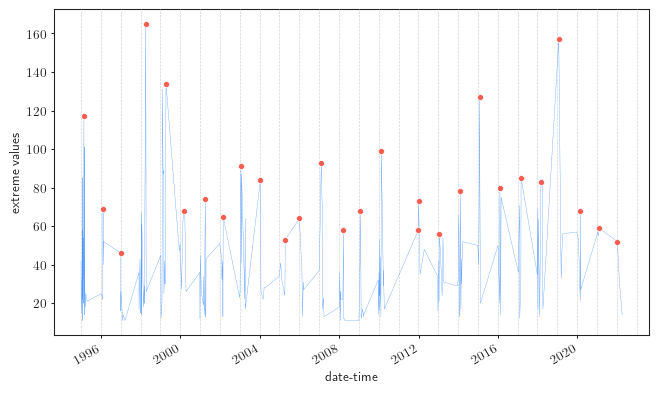

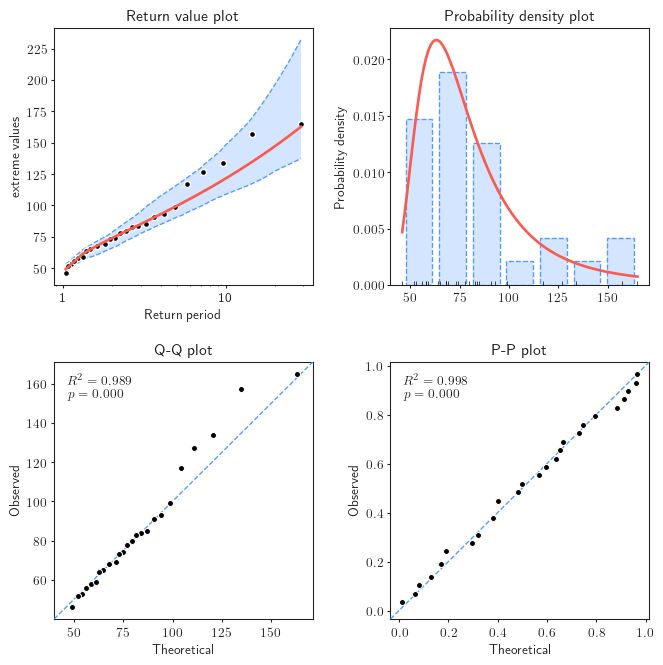

In [909]:
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)

model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model

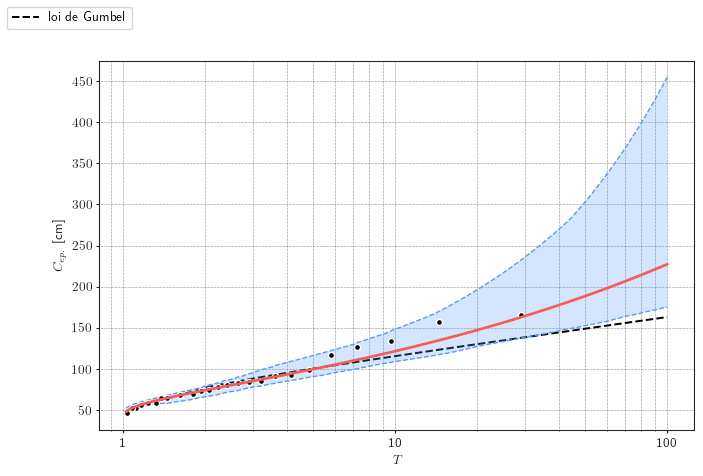

In [910]:
fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.7,
)
axes.set_xlabel(r"$T$")
axes.set_ylabel(r"$C_{ep.}$ [cm]")


calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig.savefig("LVE_Episode_poste_"+nom_commune+"(" +poste_choisi+").pdf",bbox_inches='tight')


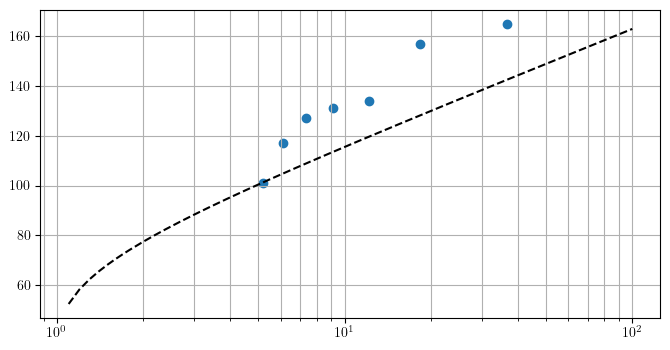

In [911]:
def période_quantile(c,m,s):
      return 1/(1-np.exp(-np.exp(-(c-m)/s)))
fig, ax = plt.subplots(figsize=(8,4))
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,1000)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
ax.semilogx(période,quantile,'--',color='black' , label = "loi de Gumbel")
y_cumul = [ float(x) for x in np.array(classement_épisode_trié)[:,1]  ]
n_s = len(y_cumul) 
n_o = (données_neige['date'].iloc[-1]-données_neige['date'].iloc[0])/ np.timedelta64(1, 'D')/365.25/n_s
x_cumul = [ n_o*(n_s+1)/(i  ) for i in range(n_s,0,-1)  ]

ax.scatter(x_cumul,y_cumul)
ax.grid(True, which="both")


 


In [912]:
classement_épisode_trié_période = [[x[0],x[1],x[2],int(période_quantile(x[1],mu,sigma))] for x in classement_épisode_trié]

print("Liste des épisodes")

print("----------  ---  -- --")
print("   date    cumul  d  T")
print(tabulate(classement_épisode_trié_période))

Liste des épisodes
----------  ---  -- --
   date    cumul  d  T
----------  ---  --  ---
02/03/1995  101   5    5
21/02/1995  117   6   10
28/01/2015  127   5   17
05/02/1999  131   5   20
12/04/1999  134   7   24
26/01/2019  157   8   74
05/04/1998  165  14  110
----------  ---  --  ---


## Comparaison avec la base de données SAFRAN (SIM2) de Météo-France

In [913]:
# Récupération des informations
url_service='https://api.geosas.fr/edr/collections/safran-isba/'
r=requests.get(url_service)
data_info=r.json()
if r.status_code == 200:
    print("La connexion est établie.")
else :
    print(colored("Il y a une erreur avec le code : {:d}.".format(r.status_code), 'red') )

La connexion est établie.


In [914]:
# outils de conversion des coordonnées
import pyproj

source_crs = 'epsg:2154' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system

# fonctions de conversion RGF93 <-> WGS
lambert_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
latlon_to_lambert = pyproj.Transformer.from_crs( target_crs,source_crs)

In [915]:
# Liste toutes les variables possibles
liste_variables_possibles = [['Nom',"Définition","unité"]]
for parametre in data_info['parameter_names']:
    name=list(parametre.keys())[0]
    liste_variables_possibles.append([name, parametre[name]['description'],parametre[name]['unit']['label'] ])
print(colored("Liste des variables accessibles :",'cyan'))
print(tabulate(liste_variables_possibles))

Liste des variables accessibles :
--------  -----------------------------------------------------------  ---------------------
Nom       Définition                                                   unité
DLI_Q     Rayonnement atmosphérique (cumul quotidien)                  Joule par centimètre²
DRAINC_Q  Drainage (cumul quotidien 06-06 UTC)                         millimetre
ETP_Q     Evapotranspiration potentielle (formule de Penman-Monteith)  millimetre
FF_Q      Vent (moyenne quotidienne)                                   mètre par seconde
PRELIQ_Q  Précipitations liquides (cumul quotidien 06-06 UTC)          millimetre
PRENEI_Q  Précipitations solide (cumul quotidien 06-06 UTC)            millimetre
SSI_Q     Rayonnement visible (cumul quotidien)                        Joule par centimètre²
SWI_Q     Indice d'humidité des sols (moyenne quotidienne 06-06 UTC)   Pourcentage
TINF_H_Q  Température minimale des 24 températures horaires            degrée Celcius
TSUP_H_Q  Température ma

In [916]:
# coordonnées en RGF93 du poste
x_poste, y_poste = latlon_to_lambert.transform(latitude_poste,longitude_poste)

translation_x = 0000 # rajout de 3 km
x_poste       = x_poste+translation_x
param_name = 'PRENEI_Q,PRELIQ_Q,T_Q'
#projection='EPSG:4326'
#coord='POINT('+str(latitude_poste)+" "+str(longitude_poste)+")"
#coord='POINT(1011370 6471230)'
coord      = 'POINT('+str(x_poste)+' '+str(y_poste)+')'
projection = 'EPSG:2154'
formatage  = 'CoverageJSON'
date       = '1980-01-01/2024-05-31'
requete    = f'https://api.geosas.fr/edr/collections/safran-isba/position?coords={coord}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete)
data=r.json()
if r.status_code == 200:
    print("J'ai récupéré les données.")
else :
    print(colored("Il y a une erreur avec le code : {:d}.".format(r.status_code), 'red') )

# coordonnées du noeud RGF93
x_safran = data['domain']['axes']['x']['value'] 
y_safran = data['domain']['axes']['y']['value'] 
# coordonnées du noeud WGS
lat_safran, lon_safran = lambert_to_latlon.transform(x_safran,y_safran)

https://api.geosas.fr/edr/collections/safran-isba/position?coords=POINT(943339.7705093649 6455833.059485071)&crs=EPSG:2154&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=CoverageJSON&datetime=1980-01-01/2024-05-31
J'ai récupéré les données.


In [917]:
safran_temps=data['domain']['axes']['t']['values']
#values=data['ranges'][param_name]['values']
safran_neige=np.array(data['ranges']['PRENEI_Q']['values'])+np.array(data['ranges']['PRELIQ_Q']['values'])
série_safran_neige=pd.DataFrame()
série_safran_neige['neige']=safran_neige
série_safran_neige['date']=pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')
display(série_safran_neige)

neige       date
0        0.0 1980-01-01
1        5.7 1980-01-02
2        5.0 1980-01-03
3        7.1 1980-01-04
4       10.2 1980-01-05
...      ...        ...
16214    6.7 2024-05-23
16215    7.0 2024-05-24
16216    0.0 2024-05-25
16217    7.0 2024-05-26
16218   14.3 2024-05-27

[16219 rows x 2 columns]

Le maximum a été atteinte le 13/02/1990 avec un cumul journalier de 107.2 mm.


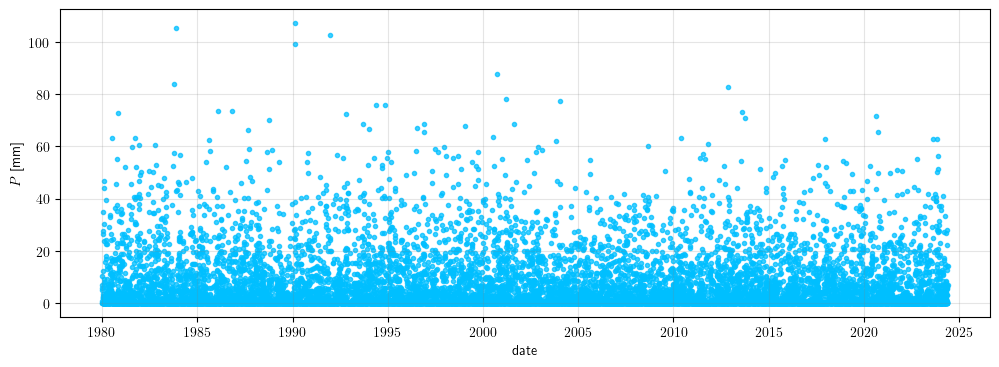

In [918]:
# distribution temporelle des distributions
#unité_variable = liste_variables_possibles[ liste_variables_possibles[:, 0] =='PRENEI_Q'][0][2]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(série_safran_neige['date'], série_safran_neige['neige'],marker = "." ,color='deepskyblue', alpha = 0.75)
ax.set_ylabel(r'$P$ [mm]')
ax.set_xlabel(r'date')
max_neige = np.nanmax(safran_neige)
date_max= série_safran_neige[série_safran_neige['neige']==max_neige]['date'] .values[0]   
# le format de données du temps est bizarre il faut supprimer les 10 dernier caractères
date_max=datetime.datetime.strptime(str(date_max)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
print("Le maximum a été atteinte le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_neige))   
plt.grid(True, color = 'gray', alpha=0.2)

#fig.savefig("Cumul_précipitations(RR)_"+nom_poste+"("+poste_choisi+").pdf",bbox_inches='tight')

In [919]:
unité_comparaison = 'M' # W: week, M: month, Y: year
sel2=données_pluie.resample(unité_comparaison, on='date')['pluie'].sum()

if dernière_année_nulle.year != 2021:
      début_sélection_mesure = dernière_année_nulle
      fin_sélection_mesure = données_pluie['date'].values[-1]
      selection_mesure =sel2[sel2.index>début_sélection_mesure]
else:
      début_sélection_mesure = données_pluie['date'].values[0]
      fin_sélection_mesure = "2020-12-31"
      selection_mesure =sel2[sel2.index<=fin_sélection_mesure]

cumul_safran=série_safran_neige.resample(unité_comparaison, on= 'date').sum()
filtrage_date = (cumul_safran.index> début_sélection_mesure) & (cumul_safran.index <= fin_sélection_mesure)
selection_safran = np.array(cumul_safran[filtrage_date])






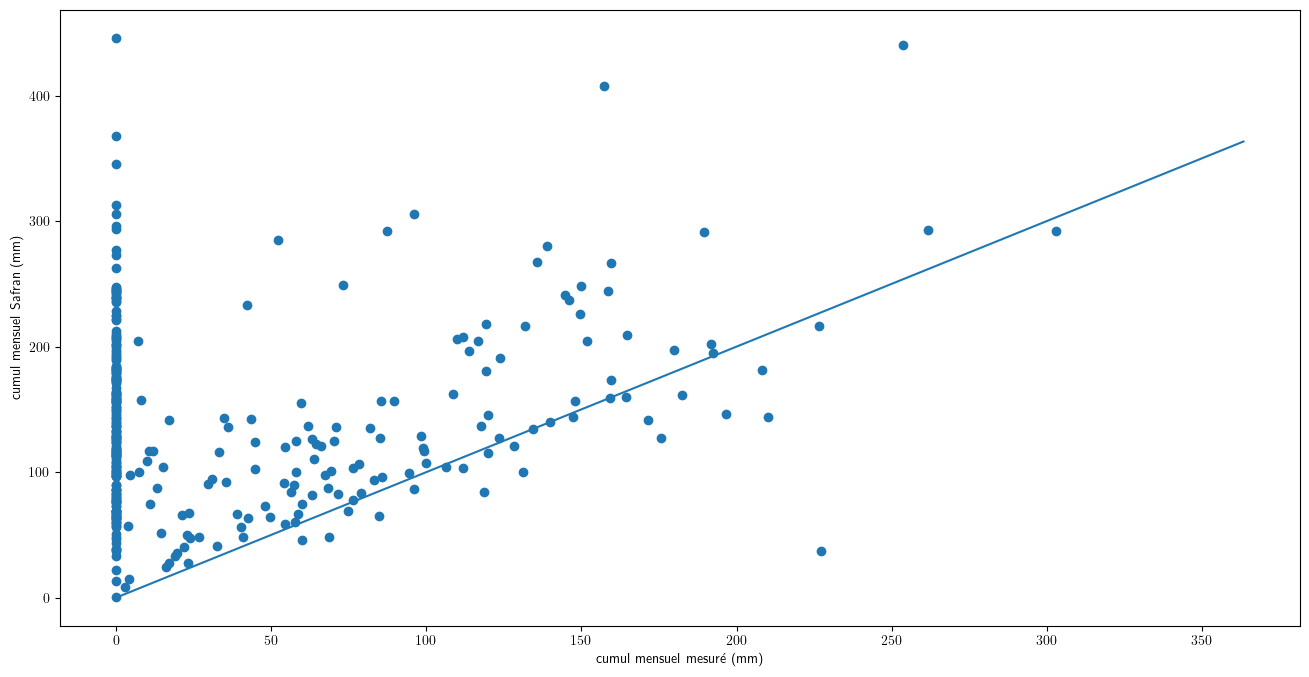

In [920]:
if selection_mesure.size == selection_safran.size:
      fig, ax = plt.subplots(figsize=(16,8))
      x = np.linspace(0,max(sel2)*1.2,10)
      ax.plot(x,x)
      ax.scatter(x=selection_mesure,y=selection_safran)
      ax.set_xlabel("cumul mensuel mesuré (mm)")
      ax.set_ylabel("cumul mensuel Safran (mm)")
      fig.savefig('comparaison_mesures2032_safran.pdf')
else:
      print(colored("Il faut ajuster la période des données car les deux échantillons n'ont pas la même longueur.",'red'))

In [921]:
# -----------trace une carte plotly avec le point de maille en spécifiant le nom de la trace pour la légende   

fig = px.scatter_mapbox(lat= [lat_safran], lon= [lon_safran], mapbox_style= "open-street-map", 
                        color_discrete_sequence= [ 'red'],
                        title= 'Noeud SAFRAN du poste de mesure', height= 1200, width= 1800,
                        zoom = 10, 
                        # labels= 'Maille la plus proche'
                       hover_name= ['Maille la plus proche'],    
                      )
fig.add_trace(go.Scattermapbox(lat= [lat_safran], lon= [lon_safran], mode= 'markers', marker= {'size': 10, 'color': 'red'}, name= 'Noeud Safran', ))
fig.add_trace(go.Scattermapbox(lat= [latitude_poste], lon= [longitude_poste], mode= 'markers', marker= {'size': 10, 'color': 'blue'}, name= 'Poste de mesure', ))
#fig.add_trace(go.Scattermapbox(lat= [lat_safran-0.036,lat_safran+0.036], lon= [lon_safran-0.036,lon_safran+0.036], 
#                               mode= 'markers', marker= {'size': 8, 'color': 'black'}, name= 'limites maille Safran', ))
 

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines", name= 'limites',
    lon = [lon_safran-0.036, lon_safran-0.036, lon_safran+0.036, lon_safran+0.036,lon_safran-0.036], 
    lat = [lat_safran-0.036, lat_safran+0.036, lat_safran+0.036, lat_safran-0.036,lat_safran-0.036],
    marker = {'size': 5}))

fig.write_image('carte_localisation_mesures2032_safran.png') 
fig


### cartes cumul de neige 2024

In [922]:
param_name='PRENEI_Q,PRELIQ_Q,T_Q'
 

box=str(longitude_poste-1)+","+str(latitude_poste-1)+","+str(longitude_poste+1)+","+str(latitude_poste+1)
 
projection='EPSG:4326'
formatage='NetCDF4'
date='2024-01-01/2024-05-31'
requete=f'https://api.geosas.fr/edr/collections/safran-isba/cube?bbox={box}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete)
if r.status_code == 200:
    print("requete ok")
else :
    print("erreur code :", r.status_code)

https://api.geosas.fr/edr/collections/safran-isba/cube?bbox=5.097667,44.158833,7.097667,46.158833&crs=EPSG:4326&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=NetCDF4&datetime=2024-01-01/2024-05-31
requete ok


In [923]:
data=xr.open_dataset(r.content)
# calcul du cumul de neige
ds2=data.PRENEI_Q.sum(dim="time")
data

<xarray.Dataset>
Dimensions:      (time: 148, y: 27, x: 25)
Coordinates:
  * time         (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-05-27
  * y            (y) float64 46.19 46.11 46.03 45.95 ... 44.35 44.27 44.19 44.11
  * x            (x) float64 5.174 5.254 5.334 5.414 ... 6.854 6.934 7.014 7.094
Data variables:
    PRENEI_Q     (time, y, x) float32 nan 0.0 0.0 0.0 0.0 ... 0.0 nan nan nan
    PRELIQ_Q     (time, y, x) float32 ...
    T_Q          (time, y, x) float32 ...
    spatial_ref  int32 ...
Attributes:
    description:  Données quotidiennes du modèle de simulation des schémas de...
    id:           safran-isba
    title:        Safran-Isba, Données changement climatique - SIM quotidienne
    crs:          EPSG:4326
    rel:          https://www.etalab.gouv.fr/licence-ouverte-open-licence/

/home/ancey/anaconda3/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



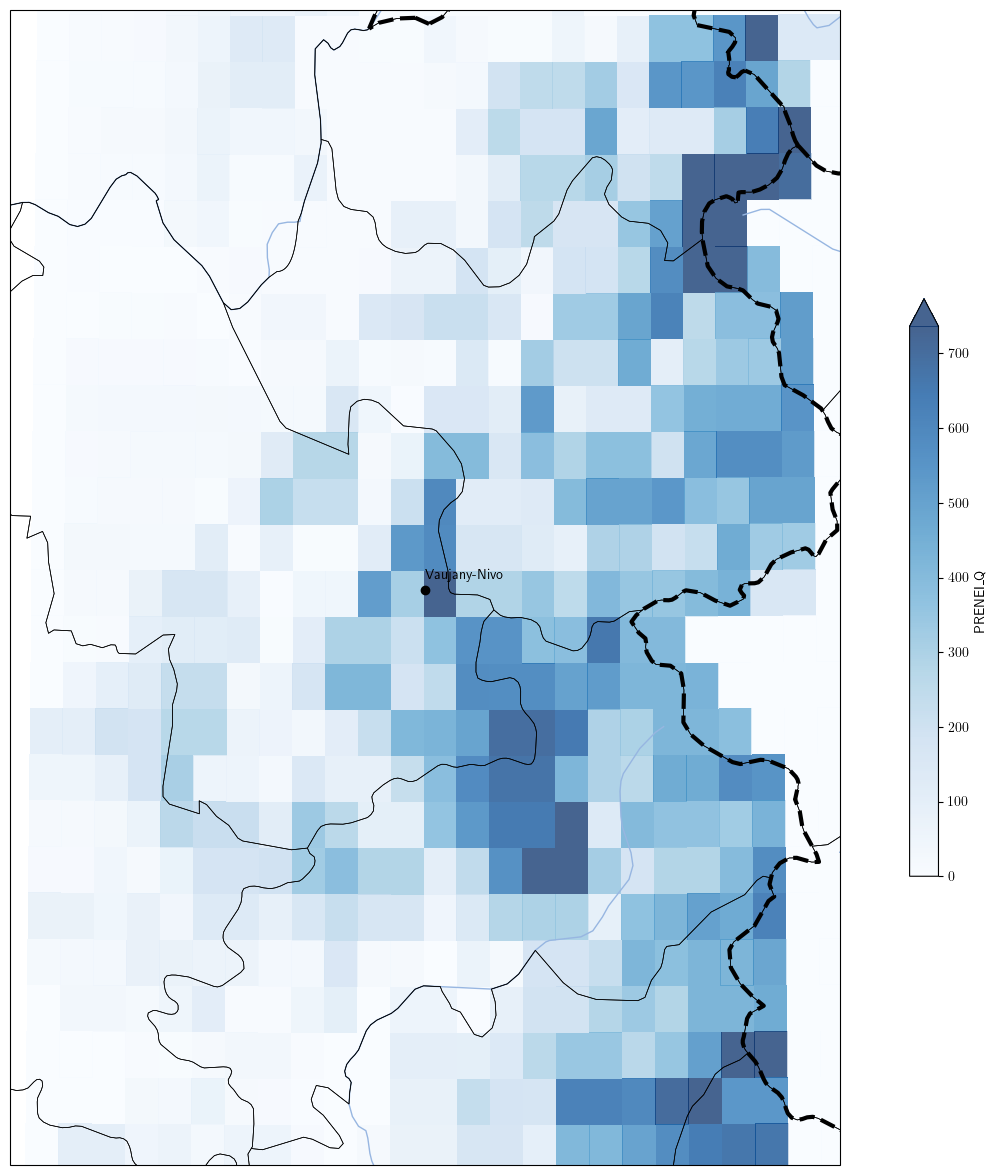

In [924]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt



#Coordonnées de la zone à représenter
lat_min, lat_max = latitude_poste-1, latitude_poste+1
lon_min, lon_max = longitude_poste-1, longitude_poste+1
central_longitude = (lon_min + lon_max) / 2
central_latitude = (lat_min + lat_max) / 2


cmap = 'Blues'
#Initialisation de la figure    
fig = plt.figure(figsize=(18,15), facecolor = 'w')
ax = plt.axes(projection = ccrs.LambertConformal(central_longitude = central_longitude,
                                                 central_latitude = central_latitude))
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

#Affichage des côtes, frontières et océans
ax.coastlines(zorder = 101)
ax.add_feature(cfeature.BORDERS, zorder = 101, color = 'black', ls = '--',linewidth=3)
ax.add_feature(cfeature.OCEAN, zorder = 99, color = 'lightgray')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES,linewidth=0.5 )
#ax.pcolormesh(ds2, cmap="bwr_r")

ds2.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "vertical", "shrink": 0.5},
    robust=True,alpha = 0.75,cmap  = cmap
)
ax.scatter( longitude_poste,latitude_poste,color = 'black')
ax.text( longitude_poste,latitude_poste+2000,nom_poste)
plt.show()

In [ ]:
# Export
fig.savefig("extrait-Safran-2024.png",bbox_inches='tight')



In [925]:
# interpolation
new_lon = np.linspace(lon_min, lon_max, 50*8)
new_lat = np.linspace(lat_min, lat_max, 54*8)
dsi = ds2.interp(y=new_lat, x=new_lon)

/home/ancey/anaconda3/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



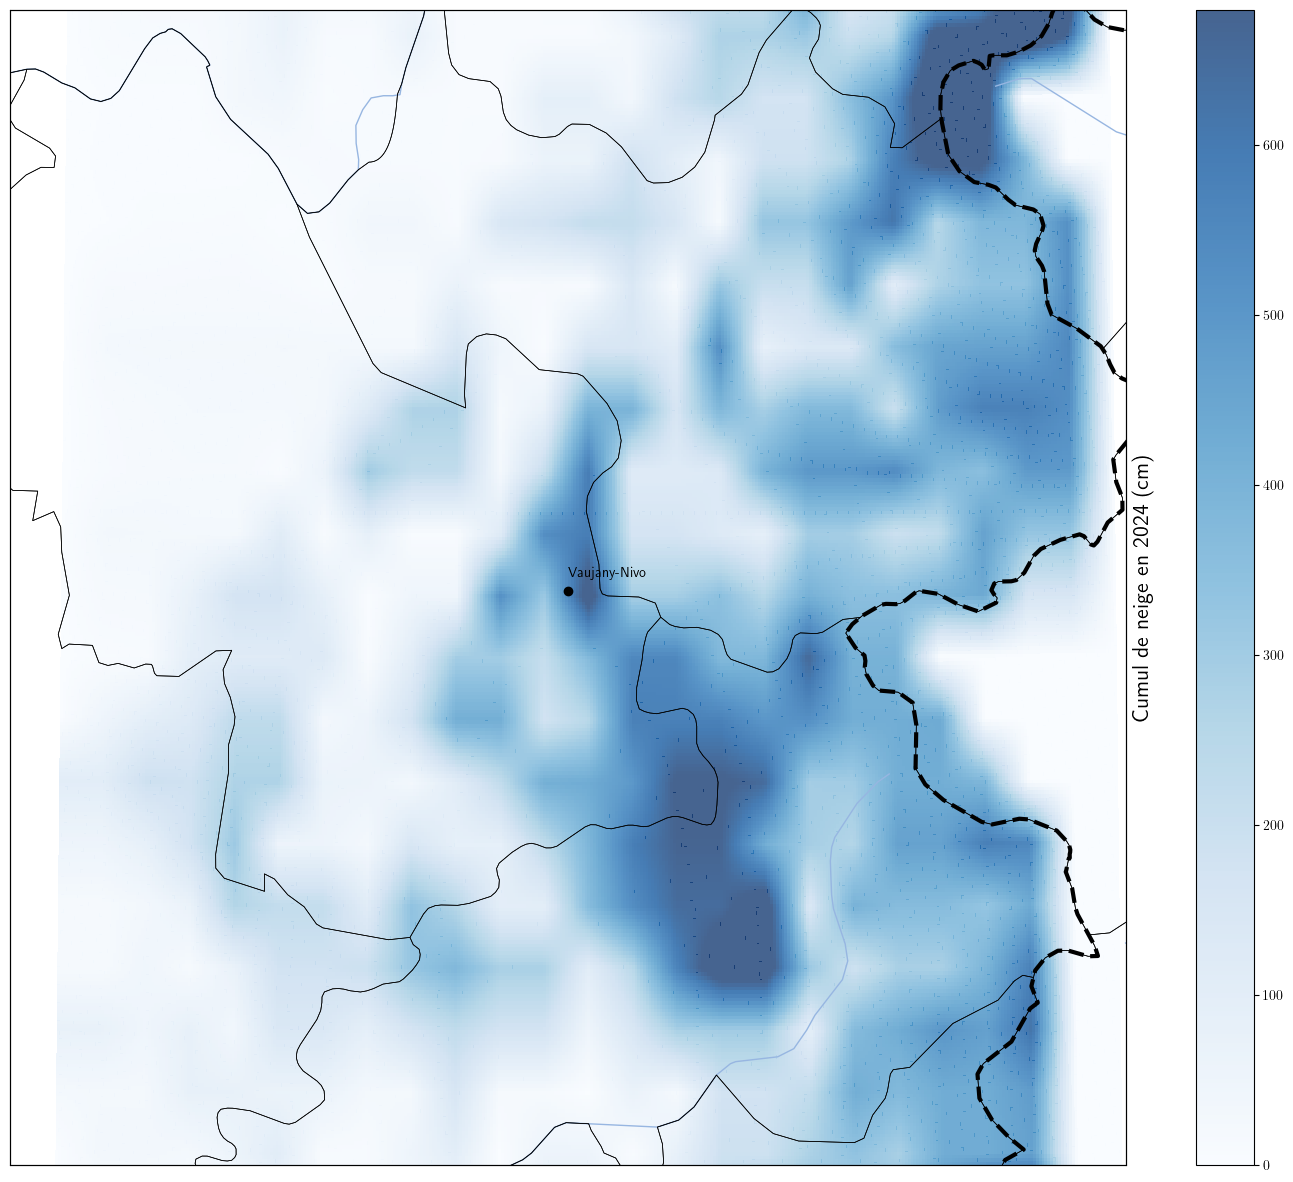

In [926]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#Coordonnées de la zone à représenter
lat_min, lat_max = latitude_poste-1, latitude_poste+1
lon_min, lon_max = longitude_poste-1, longitude_poste+1
central_longitude = (lon_min + lon_max) / 2
central_latitude = (lat_min + lat_max) / 2



#Initialisation de la figure    
fig = plt.figure(figsize=(18,15), facecolor = 'w')
ax = plt.axes(projection = ccrs.LambertConformal(central_longitude = central_longitude,
                                                 central_latitude = central_latitude))
ax.set_extent([lon_min, lon_max, lat_min, lat_max])



#Affichage des côtes, frontières et océans
ax.coastlines(zorder = 101)
ax.add_feature(cfeature.BORDERS, zorder = 101, color = 'black', ls = '--',linewidth=3)
ax.add_feature(cfeature.OCEAN, zorder = 99, color = 'lightgray')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES,linewidth=0.5 )
 

im = dsi.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    #cbar_kwargs={"orientation": "vertical", "shrink": 0.5},
  
    robust=True,add_colorbar=False,
    alpha = 0.75,cmap  = 'Blues'
)
ax.scatter( longitude_poste,latitude_poste,color = 'black')
ax.text( longitude_poste,latitude_poste+2000,nom_poste)

 
cbar = fig.colorbar(im, orientation='vertical')
#cbar.ax.set_ylabel('Cumul de neige en 2024', rotation=270,fontsize=20, position=[0.3,0.7]) 

ax2 = ax.twinx() ##Create secondary axis
ax2.set_yticks([]) ##No ticks for the secondary axis

ax2.set_ylabel('Cumul de neige en 2024 (cm)',  fontsize=16) ##Label for secondary axis
 
cbar = fig.colorbar(sc)

plt.show()

In [927]:
fig.savefig("extrait-Safran-2024.png",bbox_inches='tight')



### Cartes 2000-23

In [757]:
param_name='PRENEI_Q,PRELIQ_Q,T_Q'
 

box=str(longitude_poste-1)+","+str(latitude_poste-1)+","+str(longitude_poste+1)+","+str(latitude_poste+1)
 
projection='EPSG:4326'
formatage='NetCDF4'
date='2000-01-01/2023-12-31'
requete=f'https://api.geosas.fr/edr/collections/safran-isba/cube?bbox={box}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete)
if r.status_code == 200:
    print("requete ok")
else :
    print("erreur code :", r.status_code)

https://api.geosas.fr/edr/collections/safran-isba/cube?bbox=5.171833,43.996667,7.171833,45.996667&crs=EPSG:4326&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=NetCDF4&datetime=2000-01-01/2023-12-31
requete ok


/home/ancey/anaconda3/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



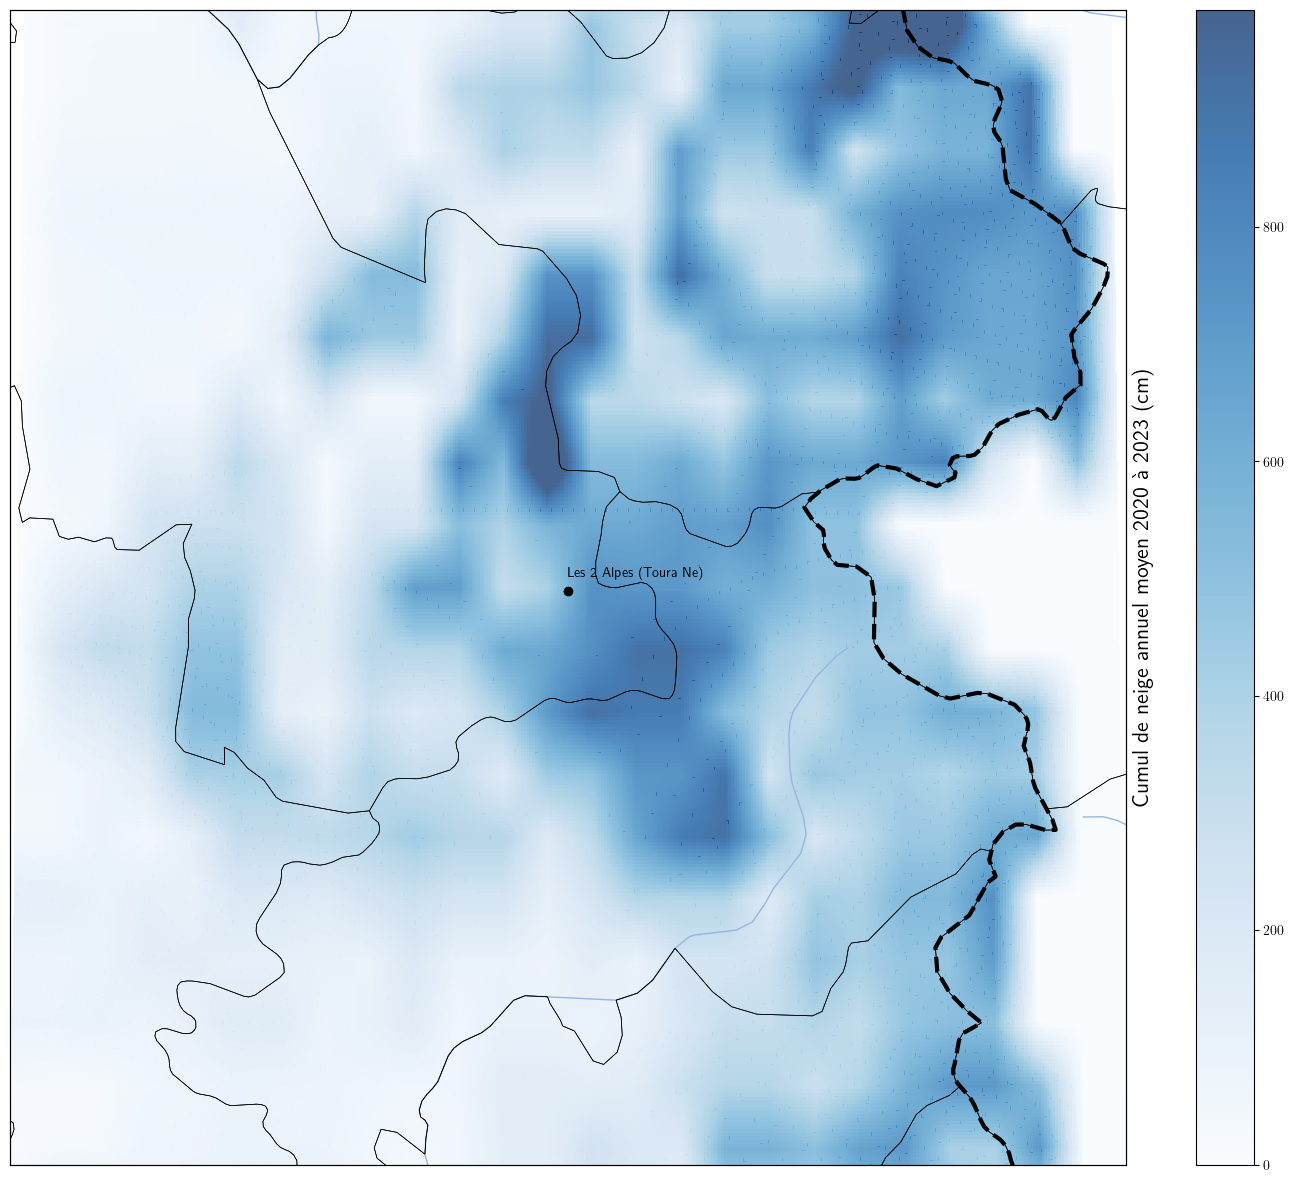

In [758]:
data=xr.open_dataset(r.content)
nombre_ans = int(date[11:15])-int(date[0:4])+1
ds2=data.PRENEI_Q.sum(dim="time")/nombre_ans # on divise la somme par le nombre d'années

new_lon = np.linspace(lon_min, lon_max, 50*8)

new_lat = np.linspace(lat_min, lat_max, 54*8)

dsi = ds2.interp(y=new_lat, x=new_lon)

#Coordonnées de la zone à représenter
lat_min, lat_max = latitude_poste-1, latitude_poste+1
lon_min, lon_max = longitude_poste-1, longitude_poste+1
central_longitude = (lon_min + lon_max) / 2
central_latitude = (lat_min + lat_max) / 2



#Initialisation de la figure    
fig = plt.figure(figsize=(18,15), facecolor = 'w')
ax = plt.axes(projection = ccrs.LambertConformal(central_longitude = central_longitude,
                                                 central_latitude = central_latitude))
ax.set_extent([lon_min, lon_max, lat_min, lat_max])



#Affichage des côtes, frontières et océans
ax.coastlines(zorder = 101)
ax.add_feature(cfeature.BORDERS, zorder = 101, color = 'black', ls = '--',linewidth=3)
ax.add_feature(cfeature.OCEAN, zorder = 99, color = 'lightgray')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES,linewidth=0.5 )
 

im = dsi.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    #cbar_kwargs={"orientation": "vertical", "shrink": 0.5},
  
    robust=True,add_colorbar=False,
    alpha = 0.75,cmap  = 'Blues'
)
ax.scatter( longitude_poste,latitude_poste,color = 'black')
ax.text( longitude_poste,latitude_poste+2000,nom_poste)

 
cbar = fig.colorbar(im, orientation='vertical')
#cbar.ax.set_ylabel('Cumul de neige en 2024', rotation=270,fontsize=20, position=[0.3,0.7]) 

ax2 = ax.twinx() ##Create secondary axis
ax2.set_yticks([]) ##No ticks for the secondary axis

ax2.set_ylabel('Cumul de neige annuel moyen 2020 à 2023 (cm)',  fontsize=16) ##Label for secondary axis
 
cbar = fig.colorbar(sc)

plt.show()

In [760]:
fig.savefig("extrait-Safran-cumul_moyen(2000-2023).png",bbox_inches='tight')